##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用联合分布的贝叶斯建模

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">View on TensorFlow.org</a>
  </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a>
  </td>
</table>

`JointDistributionSequential` 是新引入的分布式类，使用户能够快速构建贝叶斯模型原型。它支持将多个分布链接在一起，并使用 lambda 函数来引入依赖项。这旨在构建包括许多常用模型在内的中小型贝叶斯模型，如 GLM、混合效应模型、混合模型等。它可以实现贝叶斯工作流的所有必要功能：先验预测采样，它可以插入另一个更大的贝叶斯图模型或神经网络。在此 Colab 中，我们将展示一些示例以说明如何使用 `JointDistributionSequential` 来实现您的日常贝叶斯工作流


### Dependencies & Prerequisites


In [ ]:
# We will be using ArviZ, a multi-backend Bayesian diagnosis and plotting library
!pip3 install -q git+git://github.com/arviz-devs/arviz.git

In [ ]:
#@title Import and set ups{ display-mode: "form" }

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.

To do this, select "Runtime" -&gt; "Change runtime type" -&gt; "Hardware accelerator" -&gt; "GPU".

以下代码段将验证我们是否可以使用 GPU。

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


注：如果由于某种原因无法使用 GPU，则此 Colab 仍然有效。（训练将花费更长时间。）

## JointDistribution

注：当您只有一个简单的模型时，此分布类非常实用。“简单”是指链式计算图；尽管该方式在技术上适用于单一节点最多为 255（因为 Python 函数最多可以包含这么多参数）的任何 PGM。

基本理念是让用户指定一个可生成 `tfp.Distribution` 实例的 `callable` 列表，逐一用于 [PGM](https://en.wikipedia.org/wiki/Graphical_model) 中的每个顶点。`callable` 最多可具有与其列表内索引同等数量的参数。（为方便用户，参数将以与创建时相反的顺序进行传递。）在内部，我们会通过将每个先前 RV 的值传递给每个可调用对象来“遍历计算图”。这样，我们便实现了[概率的链式法则](https://en.wikipedia.org/wiki/Chain_rule_(probability%29#More_than_two_random_variables): $p({x}*i^d)=\prod_i^d p(x_i|x*{&lt;i})$。

这一理念非常简单，即便为 Python 代码。大意如下：

```python
# The chain rule of probability, manifest as Python code.
def log_prob(rvs, xs):
  # xs[:i] is rv[i]'s markov blanket. `[::-1]` just reverses the list.
  return sum(rv(*xs[i-1::-1]).log_prob(xs[i])
             for i, rv in enumerate(rvs))
```

您可以从 `JointDistributionSequential` 的文档字符串中找到更多信息，但大意是要传递一个分布列表来初始化类，如果列表中的某些分布取决于另一个上游分布/变量的输出，则只需使用 lambda 函数来对其进行封装。现在，让我们看看它的实际运行效果！

## （稳健）线性回归

出自 PyMC3 文档 [GLM：使用离群点检测的稳健回归](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


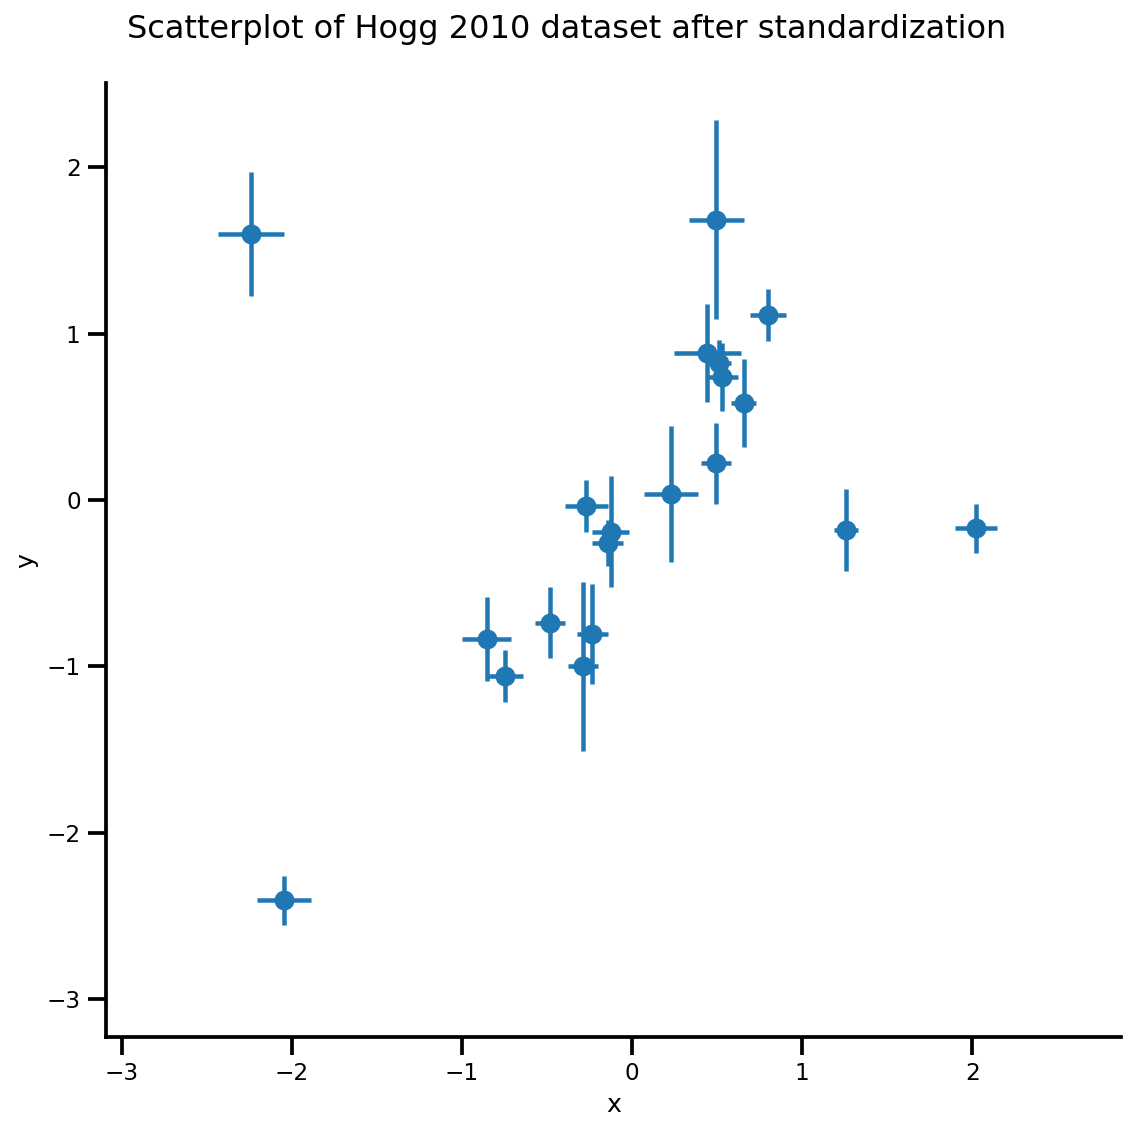

In [ ]:
#@title Get data
#@markdown Cut & pasted directly from the `fetch_hogg2010test()` function. It is identical to the original dataset as hardcoded in the Hogg 2010 paper
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

def plot_hoggs(dfhoggs):
  ## create xlims ylims for plotting
  xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5,
           dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
  ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5,
           dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

  ## scatterplot the standardized data
  g = sns.FacetGrid(dfhoggs, size=8)
  _ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
  _ = g.axes[0][0].set_ylim(ylims)
  _ = g.axes[0][0].set_xlim(xlims)

  plt.subplots_adjust(top=0.92)
  _ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)
  return g, xlims, ylims
  
g = plot_hoggs(dfhoggs)

In [ ]:
X_np = dfhoggs['x'].values
sigma_y_np = dfhoggs['sigma_y'].values
Y_np = dfhoggs['y'].values

### 传统 OLS 模型

现在，让我们建立一个线性模型，一个简单的截距 + 斜率回归问题：

In [ ]:
mdl_ols = tfd.JointDistributionSequential([
    # b0 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # x ~ Normal(b0+b1*X, 1)
    lambda b1, b0: tfd.Normal(
      # Parameter transformation
      loc=b0 + b1*X_np,
      scale=sigma_y_np)
])

然后，您可以检查模型的计算图以查看依赖关系。请注意，`x` 保留为最后一个节点的名称，您无法确定它是 JointDistributionSequential 模型中的 lambda 参数。

In [ ]:
mdl_ols.resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

从模型中采样非常简单：

In [ ]:
mdl_ols.sample()

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.50225804634794>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.682740126293564>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.33051382,  0.71443618, -1.91085683,  0.89371173, -0.45060957,
        -1.80448758, -0.21357082,  0.07891058, -0.20689721, -0.62690385,
        -0.55225748, -0.11446535, -0.66624497, -0.86913291, -0.93605552,
        -0.83965336, -0.70988597, -0.95813437,  0.15884761, -0.31113434])>]

…它提供了 tf.Tensor 列表。您可以立即将其插入 log_prob 函数以计算模型的 log_prob：

In [ ]:
prior_predictive_samples = mdl_ols.sample()
mdl_ols.log_prob(prior_predictive_samples)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-4.97502846, -3.98544303, -4.37514505, -3.46933487, -3.80688125,
       -3.42907525, -4.03263074, -3.3646366 , -4.70370938, -4.36178501,
       -3.47823735, -3.94641662, -5.76906319, -4.0944128 , -4.39310708,
       -4.47713894, -4.46307881, -3.98802372, -3.83027747, -4.64777082])>

嗯，这里有些不太对：我们应该得到一个标量 log_prob！实际上，我们可以通过调用 `.log_prob_parts` 来进一步检查是否存在问题，它给出了图模型中每个节点的 `log_prob`：

In [ ]:
mdl_ols.log_prob_parts(prior_predictive_samples)

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.9699239562734849>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-3.459364167569284>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.54574034,  0.4438451 ,  0.05414307,  0.95995326,  0.62240687,
         1.00021288,  0.39665739,  1.06465152, -0.27442125,  0.06750311,
         0.95105078,  0.4828715 , -1.33977506,  0.33487533,  0.03618104,
        -0.04785082, -0.03379069,  0.4412644 ,  0.59901066, -0.2184827 ])>]

…结果是最后一个节点并未沿 i.i.d. 维度/轴求 reduce_sum！当我们求和时，前两个变量因此被错误地广播。

这里的技巧是使用 `tfd.Independent` 重新解释批次形状（以便轴的其余部分被正确缩减）：

In [ ]:
mdl_ols_ = tfd.JointDistributionSequential([
    # b0
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda b1, b0: tfd.Independent(
        tfd.Normal(
            # Parameter transformation
            # b1 shape: (batch_shape), X shape (num_obs): we want result to have
            # shape (batch_shape, num_obs)
            loc=b0 + b1*X_np,
            scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    ),
])

现在，让我们检查模型的最后一个节点/分布，您可以看到事件形状现已正确解释。请注意，可能需要一些反复试验才能使 `reinterpreted_batch_ndims` 正确，但您始终可以轻松打印分布或采样的张量以复查形状！

In [ ]:
print(mdl_ols_.sample_distributions()[0][-1])
print(mdl_ols.sample_distributions()[0][-1])

tfp.distributions.Independent("JointDistributionSequential_sample_distributions_IndependentJointDistributionSequential_sample_distributions_Normal", batch_shape=[], event_shape=[20], dtype=float64)
tfp.distributions.Normal("JointDistributionSequential_sample_distributions_Normal", batch_shape=[20], event_shape=[], dtype=float64)


In [ ]:
prior_predictive_samples = mdl_ols_.sample()
mdl_ols_.log_prob(prior_predictive_samples)  # <== Getting a scalar correctly

<tf.Tensor: shape=(), dtype=float64, numpy=-2.543425661013286>

#### 其他 `JointDistribution*` API

In [ ]:
mdl_ols_named = tfd.JointDistributionNamed(dict(
    likelihood = lambda b0, b1: tfd.Independent(
        tfd.Normal(
            loc=b0 + b1*X_np,
            scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    ),
    b0         = tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    b1         = tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
))

mdl_ols_named.log_prob(mdl_ols_named.sample())

<tf.Tensor: shape=(), dtype=float64, numpy=-5.99620966071338>

In [ ]:
mdl_ols_named.sample()  # output is a dictionary

{'b0': <tf.Tensor: shape=(), dtype=float64, numpy=0.26364058399428225>,
 'b1': <tf.Tensor: shape=(), dtype=float64, numpy=-0.27209402374432207>,
 'likelihood': <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([ 0.6482155 , -0.39314108,  0.62744764, -0.24587987, -0.20544617,
         1.01465392, -0.04705611, -0.16618702,  0.36410134,  0.3943299 ,
         0.36455291, -0.27822219, -0.24423928,  0.24599518,  0.82731092,
        -0.21983033,  0.56753169,  0.32830481, -0.15713064,  0.23336351])>}

In [ ]:
Root = tfd.JointDistributionCoroutine.Root  # Convenient alias.
def model():
  b1 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
  b0 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
  yhat = b0 + b1*X_np
  likelihood = yield tfd.Independent(
        tfd.Normal(loc=yhat, scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    )

mdl_ols_coroutine = tfd.JointDistributionCoroutine(model)
mdl_ols_coroutine.log_prob(mdl_ols_coroutine.sample())

<tf.Tensor: shape=(), dtype=float64, numpy=-4.566678123520463>

In [ ]:
mdl_ols_coroutine.sample()  # output is a tuple

(<tf.Tensor: shape=(), dtype=float64, numpy=0.06811002171170354>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.37477064754116807>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.91615096, -0.20244718, -0.47840159, -0.26632479, -0.60441105,
        -0.48977789, -0.32422329, -0.44019322, -0.17072643, -0.20666025,
        -0.55932191, -0.40801868, -0.66893181, -0.24134135, -0.50403536,
        -0.51788596, -0.90071876, -0.47382338, -0.34821655, -0.38559724])>)

#### 最大似然估计

现在，我们可以进行推断了！您可以使用优化器来找到最大似然估计。 

In [ ]:
#@title Define some helper functions

# bfgs and lbfgs currently requries a function that returns both the value and
# gradient re the input.
import functools

def _make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

# Map a list of tensors (e.g., output from JDSeq.sample([...])) to a single tensor
# modify from tfd.Blockwise
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import tensorshape_util

class Mapper:
  """Basically, this is a bijector without log-jacobian correction."""
  def __init__(self, list_of_tensors, list_of_bijectors, event_shape):
    self.dtype = dtype_util.common_dtype(
        list_of_tensors, dtype_hint=tf.float32)
    self.list_of_tensors = list_of_tensors
    self.bijectors = list_of_bijectors
    self.event_shape = event_shape

  def flatten_and_concat(self, list_of_tensors):
    def _reshape_map_part(part, event_shape, bijector):
      part = tf.cast(bijector.inverse(part), self.dtype)
      static_rank = tf.get_static_value(ps.rank_from_shape(event_shape))
      if static_rank == 1:
        return part
      new_shape = ps.concat([
          ps.shape(part)[:ps.size(ps.shape(part)) - ps.size(event_shape)], 
          [-1]
      ], axis=-1)
      return tf.reshape(part, ps.cast(new_shape, tf.int32))

    x = tf.nest.map_structure(_reshape_map_part,
                              list_of_tensors,
                              self.event_shape,
                              self.bijectors)
    return tf.concat(tf.nest.flatten(x), axis=-1)

  def split_and_reshape(self, x):
    assertions = []
    message = 'Input must have at least one dimension.'
    if tensorshape_util.rank(x.shape) is not None:
      if tensorshape_util.rank(x.shape) == 0:
        raise ValueError(message)
    else:
      assertions.append(assert_util.assert_rank_at_least(x, 1, message=message))
    with tf.control_dependencies(assertions):
      splits = [
          tf.cast(ps.maximum(1, ps.reduce_prod(s)), tf.int32)
          for s in tf.nest.flatten(self.event_shape)
      ]
      x = tf.nest.pack_sequence_as(
          self.event_shape, tf.split(x, splits, axis=-1))
      def _reshape_map_part(part, part_org, event_shape, bijector):
        part = tf.cast(bijector.forward(part), part_org.dtype)
        static_rank = tf.get_static_value(ps.rank_from_shape(event_shape))
        if static_rank == 1:
          return part
        new_shape = ps.concat([ps.shape(part)[:-1], event_shape], axis=-1)
        return tf.reshape(part, ps.cast(new_shape, tf.int32))

      x = tf.nest.map_structure(_reshape_map_part,
                                x, 
                                self.list_of_tensors,
                                self.event_shape,
                                self.bijectors)
    return x

In [ ]:
mapper = Mapper(mdl_ols_.sample()[:-1],
                [tfb.Identity(), tfb.Identity()],
                mdl_ols_.event_shape[:-1])

# mapper.split_and_reshape(mapper.flatten_and_concat(mdl_ols_.sample()[:-1]))

In [ ]:
@_make_val_and_grad_fn
def neg_log_likelihood(x):
  # Generate a function closure so that we are computing the log_prob
  # conditioned on the observed data. Note also that tfp.optimizer.* takes a 
  # single tensor as input.
  return -mdl_ols_.log_prob(mapper.split_and_reshape(x) + [Y_np])

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=tf.zeros(2, dtype=dtype),
    tolerance=1e-20,
    x_tolerance=1e-8
)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


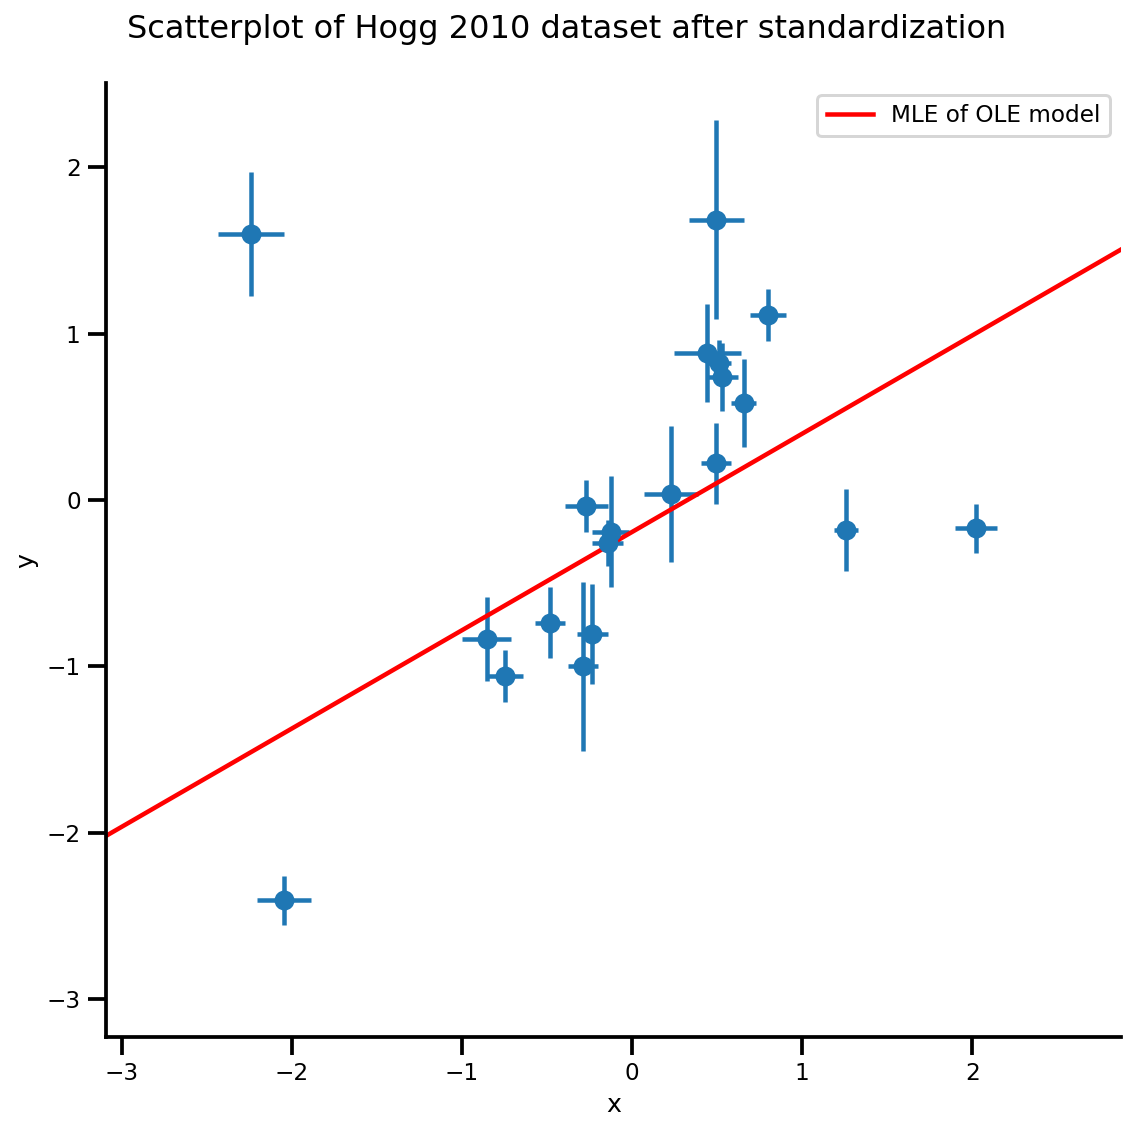

In [ ]:
b0est, b1est = lbfgs_results.position.numpy()

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, 
                  color='r', label='MLE of OLE model')
plt.legend();

#### 批处理版本模型和马尔科夫链蒙特卡洛法

在贝叶斯推断中，我们通常希望使用马尔科夫链蒙特卡洛样本，因为当样本来自后验时，我们可以将其插入到*任何*函数中来计算期望值。然而，马尔科夫链蒙特卡洛 API 要求我们编写批处理友好型模型，我们可以通过调用 `sample([...])` 来检查实际上不可“批处理”的模型

```python
mdl_ols_.sample(5)  # <== error as some computation could not be broadcasted.
```

此例相对简单，因为我们的模型中只有一个线性函数，扩展形状应该奏效：

In [ ]:
mdl_ols_batch = tfd.JointDistributionSequential([
    # b0
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda b1, b0: tfd.Independent(
        tfd.Normal(
            # Parameter transformation
            loc=b0[..., tf.newaxis] + b1[..., tf.newaxis]*X_np[tf.newaxis, ...],
            scale=sigma_y_np[tf.newaxis, ...]),
        reinterpreted_batch_ndims=1
    ),
])

mdl_ols_batch.resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

我们可以再次对 log_prob_parts 进行采样和评估以进行一些检查：

In [ ]:
b0, b1, y = mdl_ols_batch.sample(4)
mdl_ols_batch.log_prob_parts([b0, b1, y])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1.25230168, -1.45281432, -1.87110061, -1.07665206])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1.07019936, -1.59562117, -2.53387765, -1.01557632])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.45841406,  2.56829635, -4.84973951, -5.59423992])>]

一些附注：

- 我们希望使用批处理版本模型，因为它对于多链马尔科夫链蒙特卡洛法来说速度最快。如果您无法将模型重写为批处理版本（例如 ODE 模型），您可以使用 `tf.map_fn` 映射 log_prob 函数以达到相同的效果。
- 现在，由于我们具有先验标量，因此 `mdl_ols_batch.sample()` 可能不起作用，原因是我们不能执行 `scalar_tensor[:, None]`。这里的解决方案是通过封装 `tfd.Sample(..., sample_shape=1)` 将标量张量扩展到 1 阶。
- 将模型编写为函数是一种很好的做法，这样您就可以更轻松地更改超参数等设置。 

In [ ]:
def gen_ols_batch_model(X, sigma, hyperprior_mean=0, hyperprior_scale=1):
  hyper_mean = tf.cast(hyperprior_mean, dtype)
  hyper_scale = tf.cast(hyperprior_scale, dtype)
  return tfd.JointDistributionSequential([
      # b0
      tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
      # b1
      tfd.Sample(tfd.Normal(loc=hyper_mean, scale=hyper_scale), sample_shape=1),
      # likelihood
      lambda b1, b0: tfd.Independent(
          tfd.Normal(
              # Parameter transformation
              loc=b0 + b1*X,
              scale=sigma),
          reinterpreted_batch_ndims=1
      ),
  ], validate_args=True)

mdl_ols_batch = gen_ols_batch_model(X_np[tf.newaxis, ...],
                                    sigma_y_np[tf.newaxis, ...])

_ = mdl_ols_batch.sample()
_ = mdl_ols_batch.sample(4)
_ = mdl_ols_batch.sample([3, 4])

In [ ]:
# Small helper function to validate log_prob shape (avoid wrong broadcasting)
def validate_log_prob_part(model, batch_shape=1, observed=-1):
  samples = model.sample(batch_shape)
  logp_part = list(model.log_prob_parts(samples))
  
  # exclude observed node
  logp_part.pop(observed)
  for part in logp_part:
    tf.assert_equal(part.shape, logp_part[-1].shape)

validate_log_prob_part(mdl_ols_batch, 4)

In [ ]:
#@title More checks: comparing the generated log_prob fucntion with handwrittent TFP log_prob function. { display-mode: "form" }

def ols_logp_batch(b0, b1, Y):
  b0_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.) # b0
  b1_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.) # b1
  likelihood = tfd.Normal(loc=b0 + b1*X_np[None, :],
                          scale=sigma_y_np) # likelihood
  return tf.reduce_sum(b0_prior.log_prob(b0), axis=-1) +\
         tf.reduce_sum(b1_prior.log_prob(b1), axis=-1) +\
         tf.reduce_sum(likelihood.log_prob(Y), axis=-1)

b0, b1, x = mdl_ols_batch.sample(4)
print(mdl_ols_batch.log_prob([b0, b1, Y_np]).numpy()) 
print(ols_logp_batch(b0, b1, Y_np).numpy())

[-227.37899384 -327.10043743 -570.44162789 -702.79808683]
[-227.37899384 -327.10043743 -570.44162789 -702.79808683]


#### 使用 No-U-Turn 采样器的马尔科夫链蒙特卡洛法


In [ ]:
#@title A common `run_chain` function
@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=500, burnin=50):

  def trace_fn(_, pkr):
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
           )
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn,
      step_size=step_size),
    bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin,
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
        inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
  )

  # Sampling from the chain.
  chain_state, sampler_stat = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=hmc,
      trace_fn=trace_fn)
  return chain_state, sampler_stat

In [ ]:
nchain = 10
b0, b1, _ = mdl_ols_batch.sample(nchain)
init_state = [b0, b1]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1]]
target_log_prob_fn = lambda *x: mdl_ols_batch.log_prob(x + (Y_np, ))

# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
]

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

In [ ]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['b0', 'b1']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

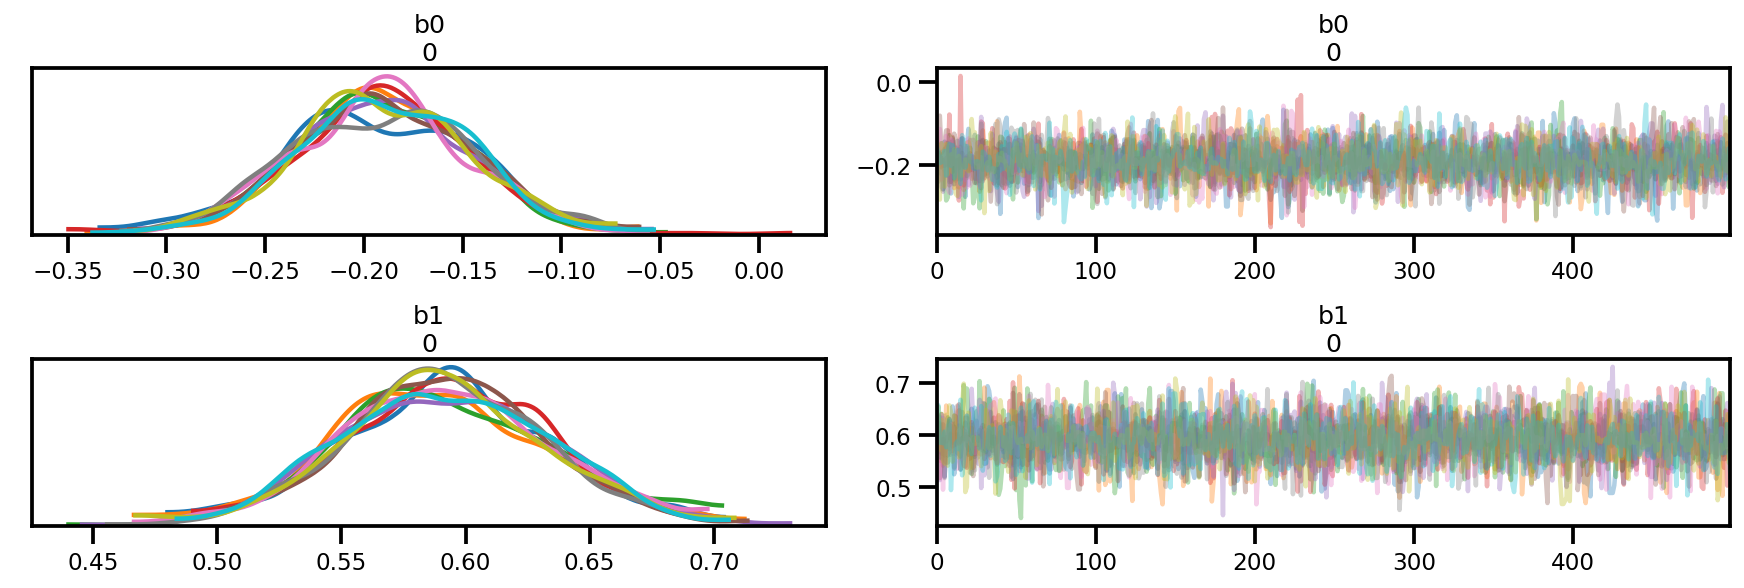

In [ ]:
az.plot_trace(az_trace);

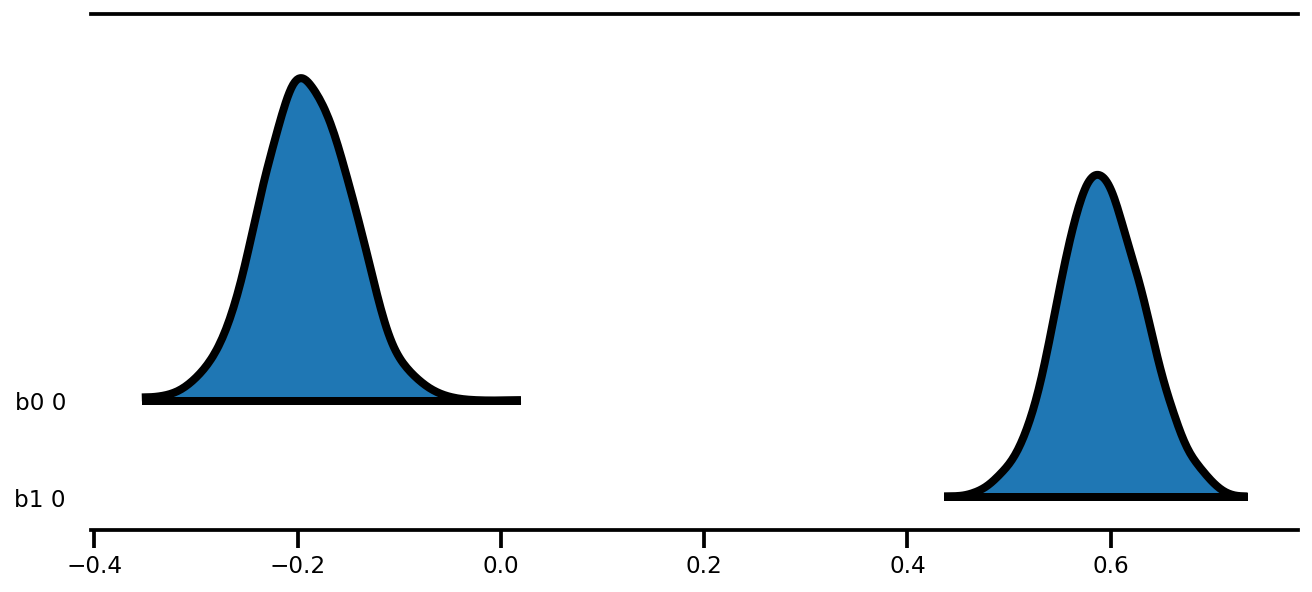

In [ ]:
az.plot_forest(az_trace,
               kind='ridgeplot',
               linewidth=4,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(9, 4));

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  


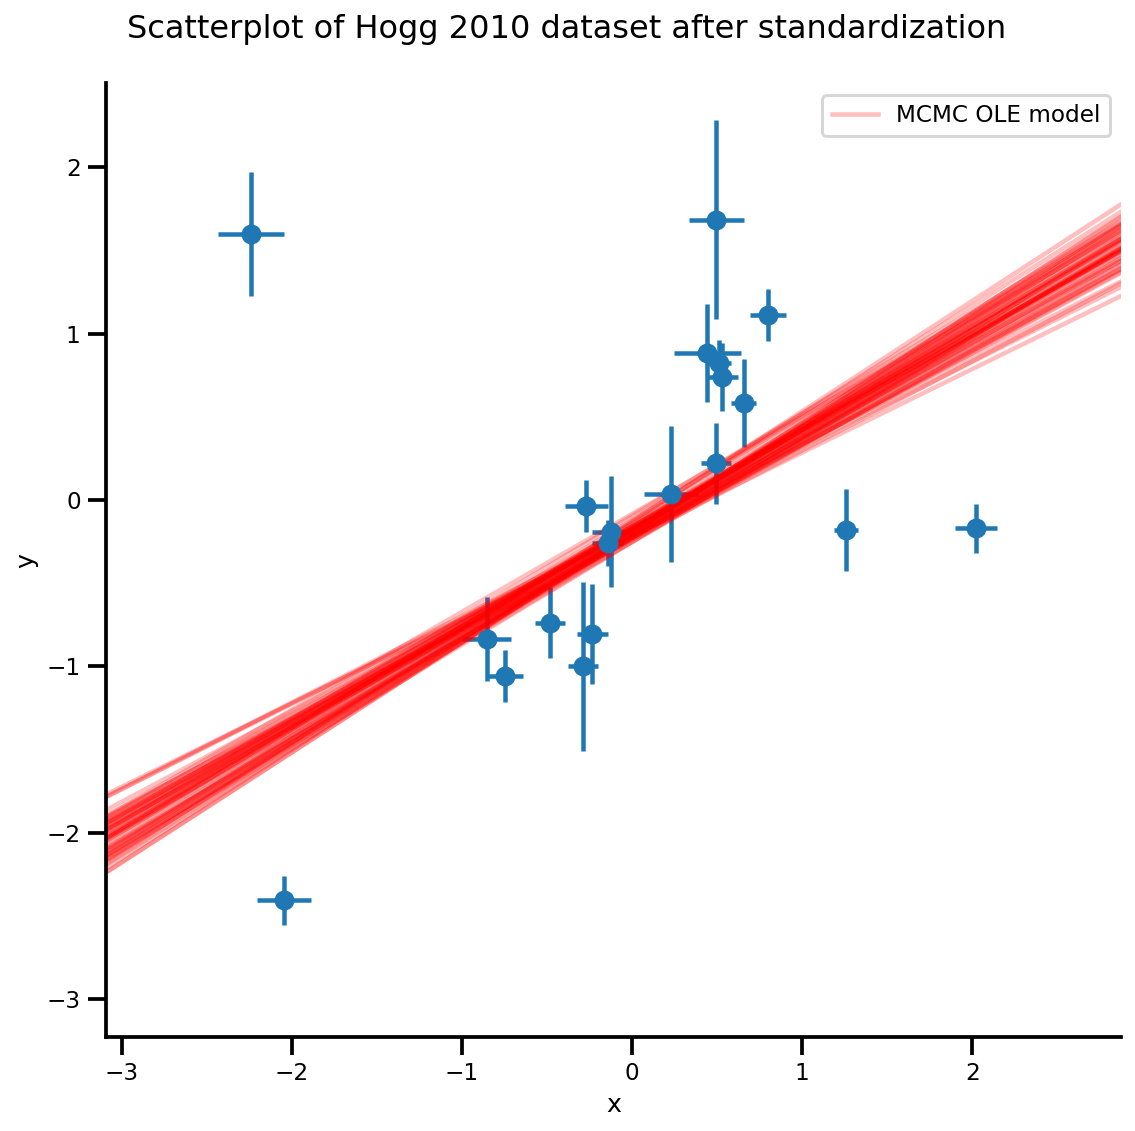

In [ ]:
k = 5
b0est, b1est = az_trace.posterior['b0'][:, -k:].values, az_trace.posterior['b1'][:, -k:].values

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)[None, :]
g.axes[0][0].plot(np.tile(xrange, (k, 1)).T,
                  (np.reshape(b0est, [-1, 1]) + np.reshape(b1est, [-1, 1])*xrange).T,
                  alpha=.25, color='r')
plt.legend([g.axes[0][0].lines[-1]], ['MCMC OLE model']);

### Student-T 方法

请注意，我们从现在开始将始终使用批处理版本模型

In [ ]:
def gen_studentt_model(X, sigma,
                       hyper_mean=0, hyper_scale=1, lower=1, upper=100):
  loc = tf.cast(hyper_mean, dtype)
  scale = tf.cast(hyper_scale, dtype)
  low = tf.cast(lower, dtype)
  high = tf.cast(upper, dtype)
  return tfd.JointDistributionSequential([
      # b0 ~ Normal(0, 1)
      tfd.Sample(tfd.Normal(loc, scale), sample_shape=1),
      # b1 ~ Normal(0, 1)
      tfd.Sample(tfd.Normal(loc, scale), sample_shape=1),
      # df ~ Uniform(a, b)
      tfd.Sample(tfd.Uniform(low, high), sample_shape=1),
      # likelihood ~ StudentT(df, f(b0, b1), sigma_y)
      #   Using Independent to ensure the log_prob is not incorrectly broadcasted.
      lambda df, b1, b0: tfd.Independent(
          tfd.StudentT(df=df, loc=b0 + b1*X, scale=sigma)),
  ], validate_args=True)

mdl_studentt = gen_studentt_model(X_np[tf.newaxis, ...],
                                  sigma_y_np[tf.newaxis, ...])
mdl_studentt.resolve_graph()

(('b0', ()), ('b1', ()), ('df', ()), ('x', ('df', 'b1', 'b0')))

In [ ]:
validate_log_prob_part(mdl_studentt, 4)

#### 前向采样（先验预测采样）

In [ ]:
b0, b1, df, x = mdl_studentt.sample(1000)
x.shape

TensorShape([1000, 20])

#### 最大似然估计

In [ ]:
# bijector to map contrained parameters to real
a, b = tf.constant(1., dtype), tf.constant(100., dtype),

# Interval transformation
tfp_interval = tfb.Inline(
    inverse_fn=(
        lambda x: tf.math.log(x - a) - tf.math.log(b - x)),
    forward_fn=(
        lambda y: (b - a) * tf.sigmoid(y) + a),
    forward_log_det_jacobian_fn=(
        lambda x: tf.math.log(b - a) - 2 * tf.nn.softplus(-x) - x),
    forward_min_event_ndims=0,
    name="interval")

unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfp_interval,
]

mapper = Mapper(mdl_studentt.sample()[:-1],
                unconstraining_bijectors,
                mdl_studentt.event_shape[:-1])

In [ ]:
@_make_val_and_grad_fn
def neg_log_likelihood(x):
  # Generate a function closure so that we are computing the log_prob
  # conditioned on the observed data. Note also that tfp.optimizer.* takes a 
  # single tensor as input, so we need to do some slicing here:
  return -tf.squeeze(mdl_studentt.log_prob(
      mapper.split_and_reshape(x) + [Y_np]))

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=mapper.flatten_and_concat(mdl_studentt.sample()[:-1]),
    tolerance=1e-20,
    x_tolerance=1e-20
)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


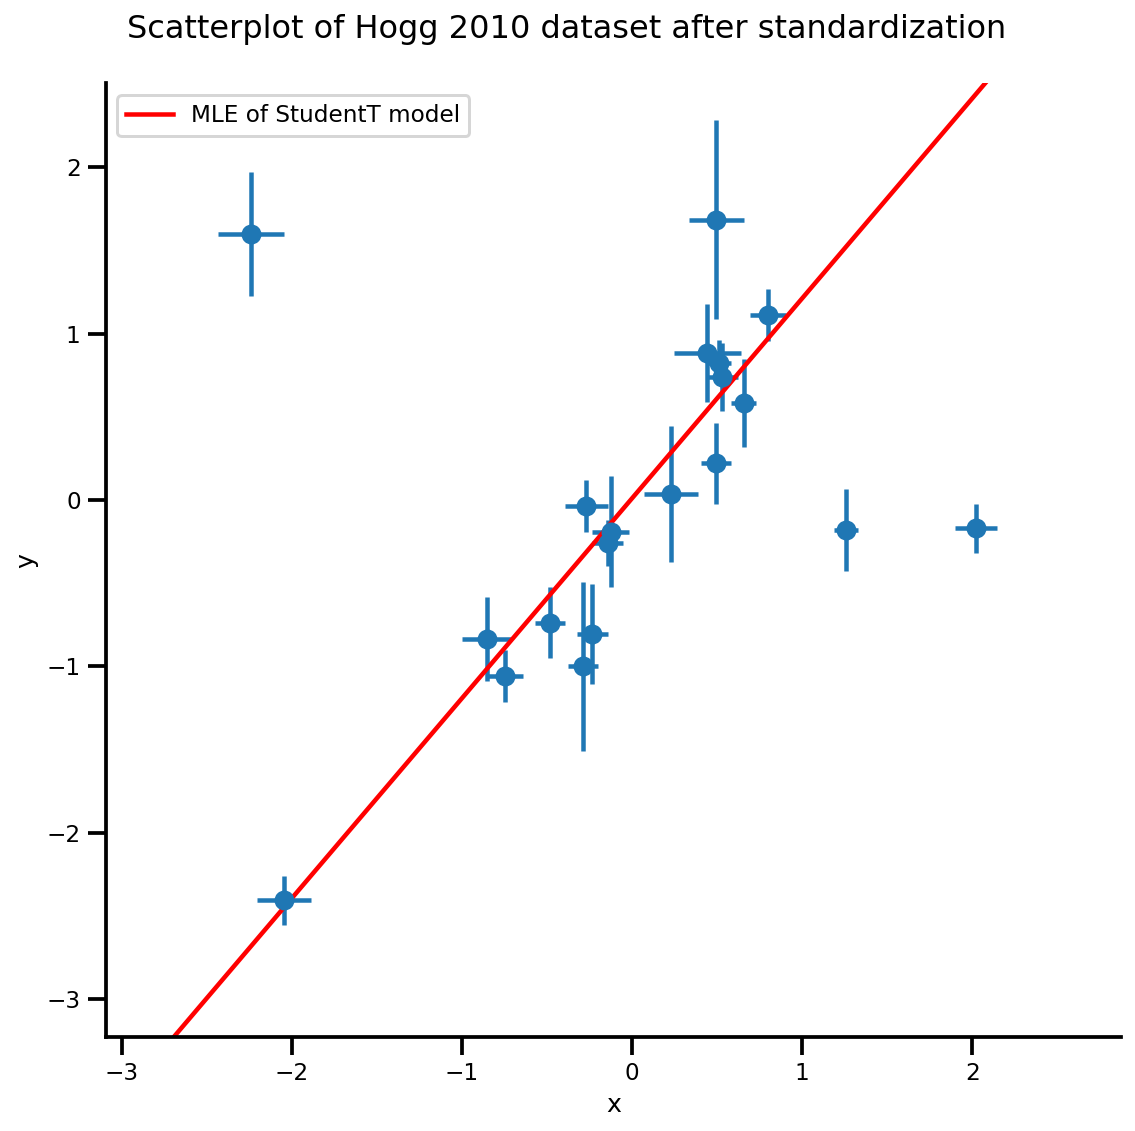

In [ ]:
b0est, b1est, dfest = lbfgs_results.position.numpy()

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, 
                  color='r', label='MLE of StudentT model')
plt.legend();

#### 马尔科夫链蒙特卡洛法

In [ ]:
nchain = 10
b0, b1, df, _ = mdl_studentt.sample(nchain)
init_state = [b0, b1, df]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1, .05]]

target_log_prob_fn = lambda *x: mdl_studentt.log_prob(x + (Y_np, ))

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors, burnin=100)

In [ ]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['b0', 'b1', 'df']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

In [ ]:
az.summary(az_trace)

mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
b0[0] -0.007  0.086  -0.164    0.157  ...  2308.0    3455.0    3293.0   1.00
b1[0]  1.203  0.095   1.029    1.389  ...  2613.0    2692.0    2938.0   1.00
df[0]  1.471  0.376   1.001    2.162  ...   448.0     426.0     454.0   1.02

[3 rows x 11 columns]

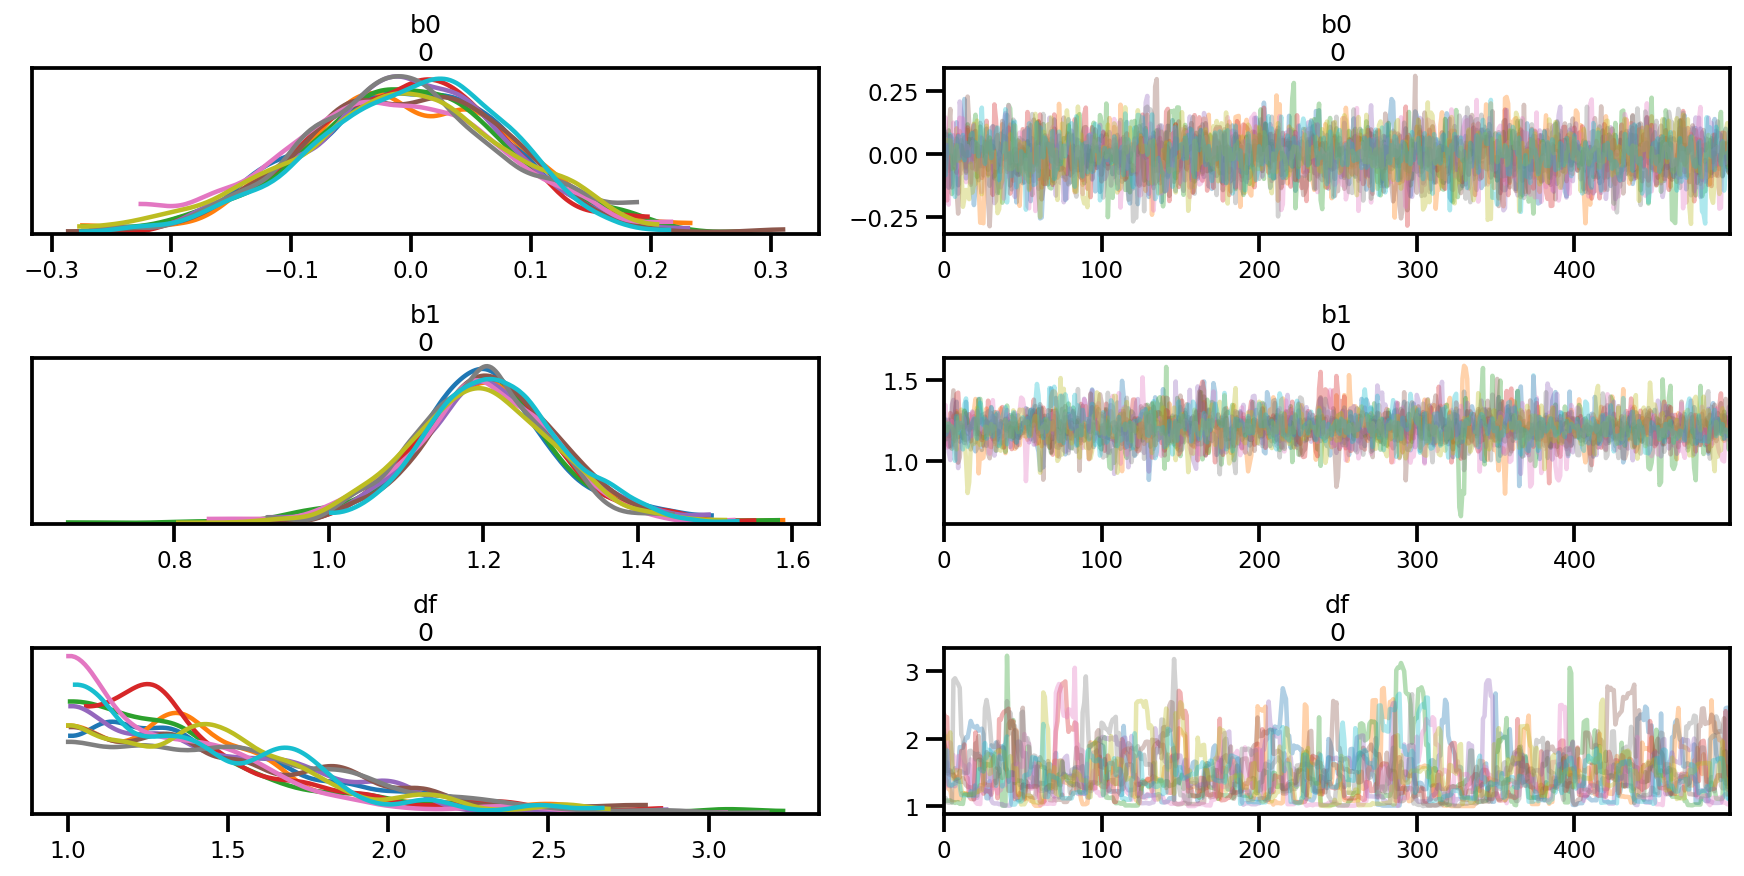

In [ ]:
az.plot_trace(az_trace);

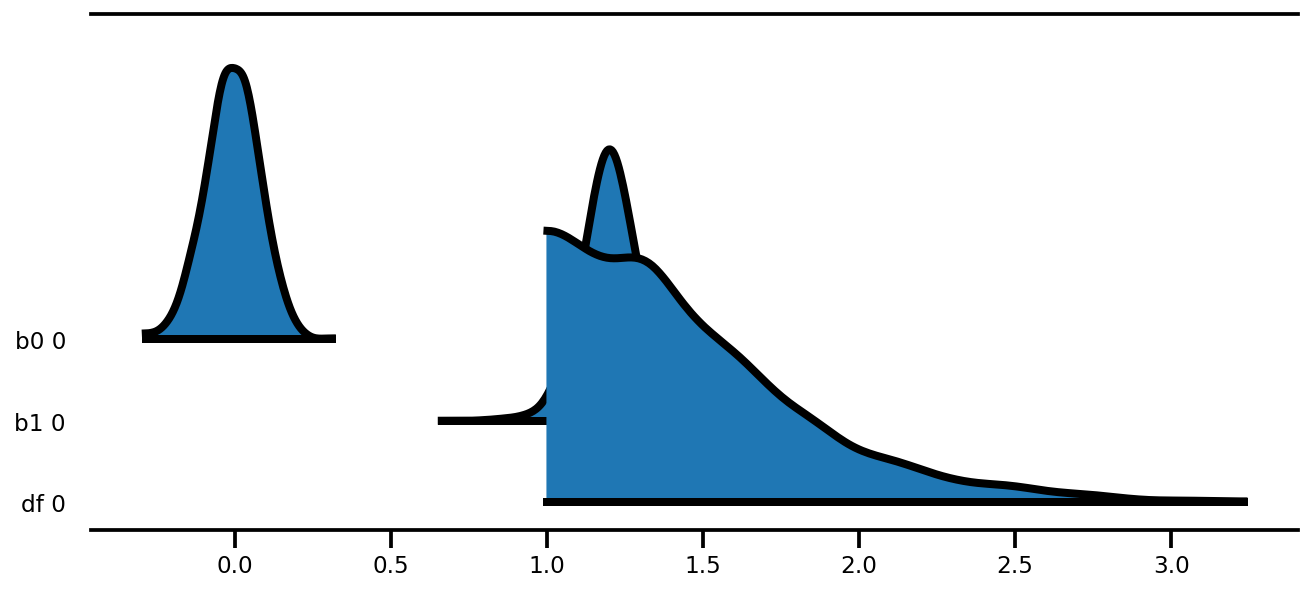

In [ ]:
az.plot_forest(az_trace,
               kind='ridgeplot',
               linewidth=4,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(9, 4));

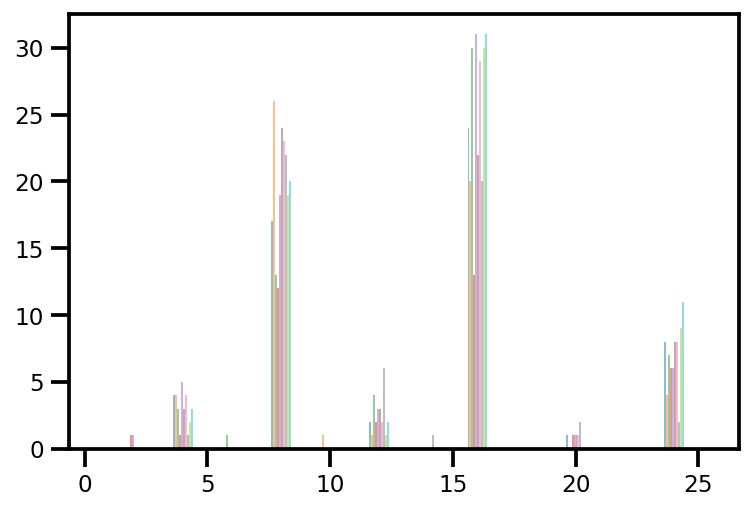

In [ ]:
plt.hist(az_trace.sample_stats['tree_size'], np.linspace(.5, 25.5, 26), alpha=.5);

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  


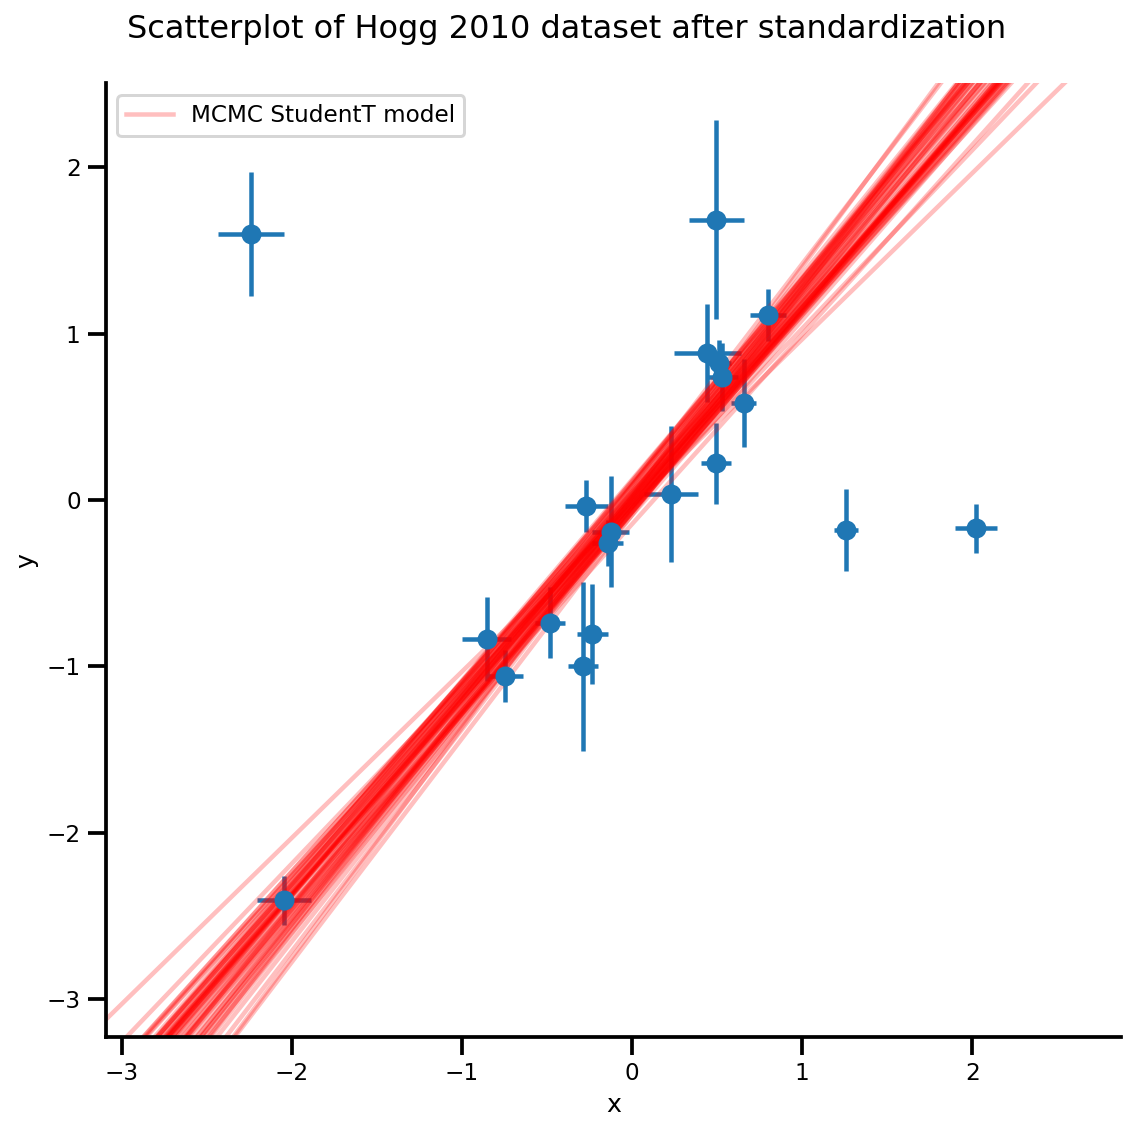

In [ ]:
k = 5
b0est, b1est = az_trace.posterior['b0'][:, -k:].values, az_trace.posterior['b1'][:, -k:].values

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)[None, :]
g.axes[0][0].plot(np.tile(xrange, (k, 1)).T,
                  (np.reshape(b0est, [-1, 1]) + np.reshape(b1est, [-1, 1])*xrange).T,
                  alpha=.25, color='r')
plt.legend([g.axes[0][0].lines[-1]], ['MCMC StudentT model']);

## 分层部分池化

出自 PyMC3 [来自 Efron 和 Morris (1975) 的 18 名球员的棒球数据](https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html#Hierarchical-Partial-Pooling)

In [ ]:
data = pd.read_table('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/efron-morris-75-data.tsv',
                     sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T
n = len(at_bats)

In [ ]:
def gen_baseball_model(at_bats, rate=1.5, a=0, b=1):
  return tfd.JointDistributionSequential([
    # phi
    tfd.Uniform(low=tf.cast(a, dtype), high=tf.cast(b, dtype)),
    # kappa_log
    tfd.Exponential(rate=tf.cast(rate, dtype)),
    # thetas
    lambda kappa_log, phi: tfd.Sample(
        tfd.Beta(
            concentration1=tf.exp(kappa_log)*phi,
            concentration0=tf.exp(kappa_log)*(1.0-phi)),
        sample_shape=n
    ),
    # likelihood
    lambda thetas: tfd.Independent(
        tfd.Binomial(
            total_count=tf.cast(at_bats, dtype),
            probs=thetas
        )), 
])

mdl_baseball = gen_baseball_model(at_bats)
mdl_baseball.resolve_graph()

(('phi', ()),
 ('kappa_log', ()),
 ('thetas', ('kappa_log', 'phi')),
 ('x', ('thetas',)))

#### 前向采样（先验预测采样）

In [ ]:
phi, kappa_log, thetas, y = mdl_baseball.sample(4)
# phi, kappa_log, thetas, y

再次注意，如果您不使用 Independent，最终会得到具有错误 batch_shape 的 log_prob。

In [ ]:
  # check logp
pprint(mdl_baseball.log_prob_parts([phi, kappa_log, thetas, hits]))
print(mdl_baseball.log_prob([phi, kappa_log, thetas, hits]))

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0., 0., 0., 0.])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.1721297 , -0.95946498, -0.72591188,  0.23993813])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([59.35192283,  7.0650634 ,  0.83744911, 74.14370935])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-3279.75191016,  -931.10438484,  -512.59197688, -1131.08043597])>]
tf.Tensor([-3220.22785762  -924.99878641  -512.48043966 -1056.69678849], shape=(4,), dtype=float64)


### 最大似然估计

`tfp.optimizer` 的一个非常惊人的功能是，您可以并行优化 k 批起点并指定 `stopping_condition` kwarg：您可以将其设置为 `tfp.optimizer.converged_all` 以查看它们是否全部找到相同的最小值，或设置为 `tfp.optimizer.converged_any` 以快速找到局部解。

In [ ]:
unconstraining_bijectors = [
    tfb.Sigmoid(),
    tfb.Exp(),
    tfb.Sigmoid(),
]

phi, kappa_log, thetas, y = mdl_baseball.sample(10)

mapper = Mapper([phi, kappa_log, thetas],
                unconstraining_bijectors,
                mdl_baseball.event_shape[:-1])

In [ ]:
@_make_val_and_grad_fn
def neg_log_likelihood(x):
  return -mdl_baseball.log_prob(mapper.split_and_reshape(x) + [hits])

start = mapper.flatten_and_concat([phi, kappa_log, thetas])

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    num_correction_pairs=10,
    initial_position=start,
    # lbfgs actually can work in batch as well
    stopping_condition=tfp.optimizer.converged_any,
    tolerance=1e-50,
    x_tolerance=1e-50,
    parallel_iterations=10,
    max_iterations=200
)

In [ ]:
lbfgs_results.converged.numpy(), lbfgs_results.failed.numpy()

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]))

In [ ]:
result = lbfgs_results.position[lbfgs_results.converged & ~lbfgs_results.failed]
result

<tf.Tensor: shape=(0, 20), dtype=float64, numpy=array([], shape=(0, 20), dtype=float64)>

LBFGS 没有收敛。

In [ ]:
if result.shape[0] > 0:
  phi_est, kappa_est, theta_est = mapper.split_and_reshape(result)
  phi_est, kappa_est, theta_est

### 马尔科夫链蒙特卡洛法

In [ ]:
target_log_prob_fn = lambda *x: mdl_baseball.log_prob(x + (hits, ))

nchain = 4
phi, kappa_log, thetas, _ = mdl_baseball.sample(nchain)
init_state = [phi, kappa_log, thetas]
step_size=[tf.cast(i, dtype=dtype) for i in [.1, .1, .1]]

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
    burnin=200)

In [ ]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['phi', 'kappa_log', 'thetas']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

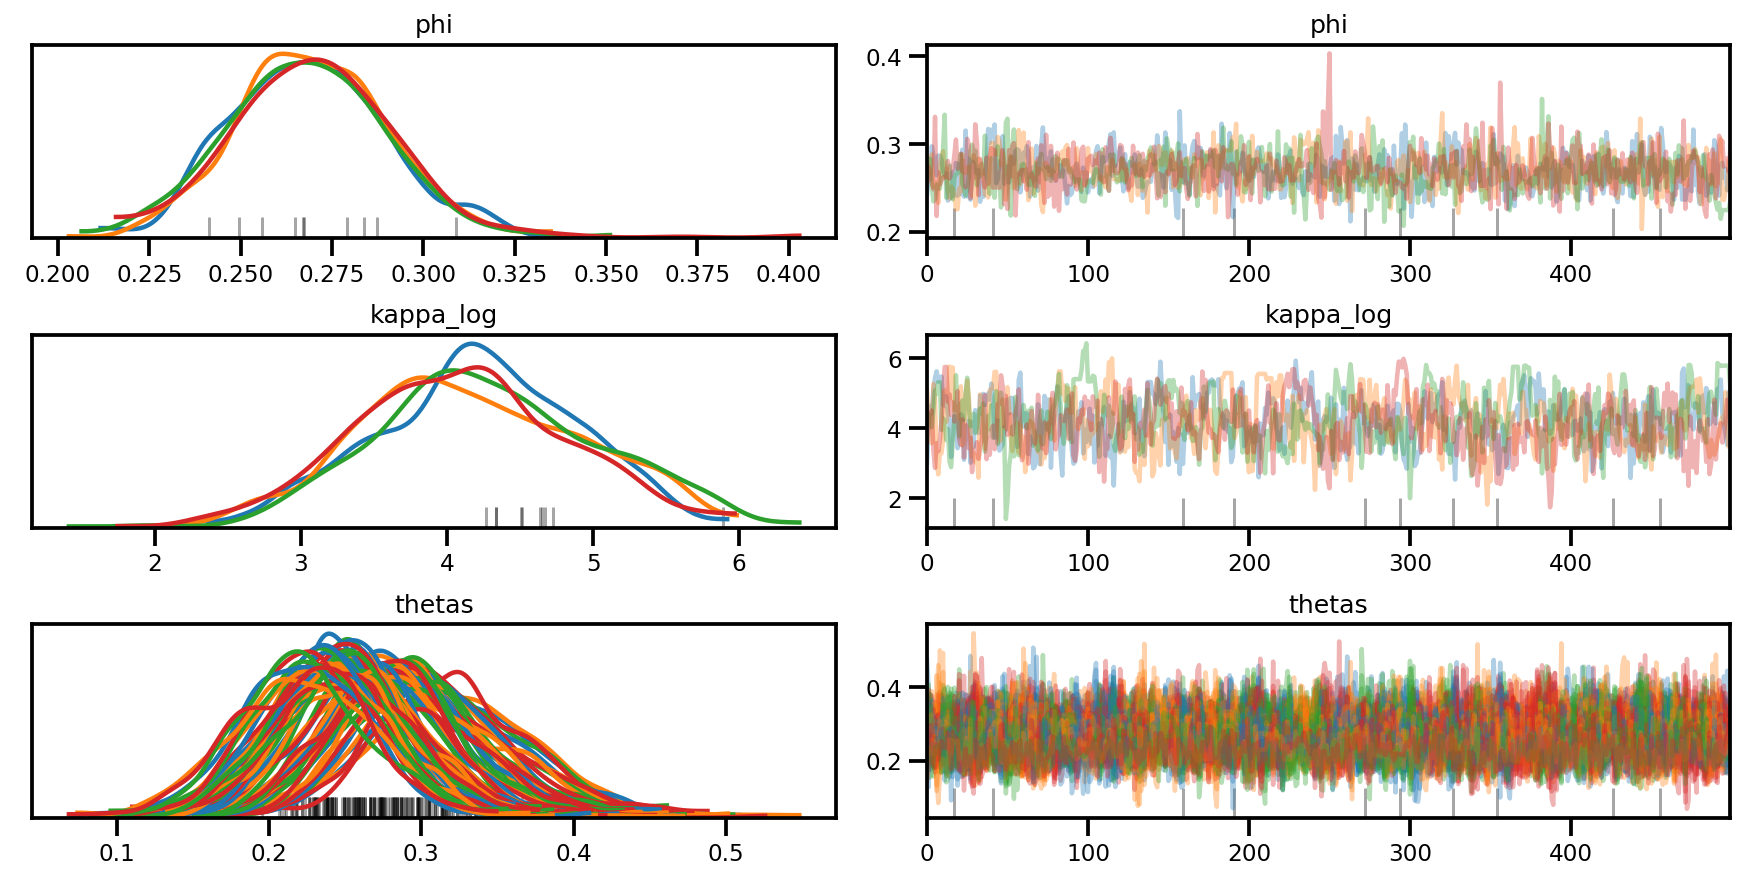

In [ ]:
az.plot_trace(az_trace, compact=True);

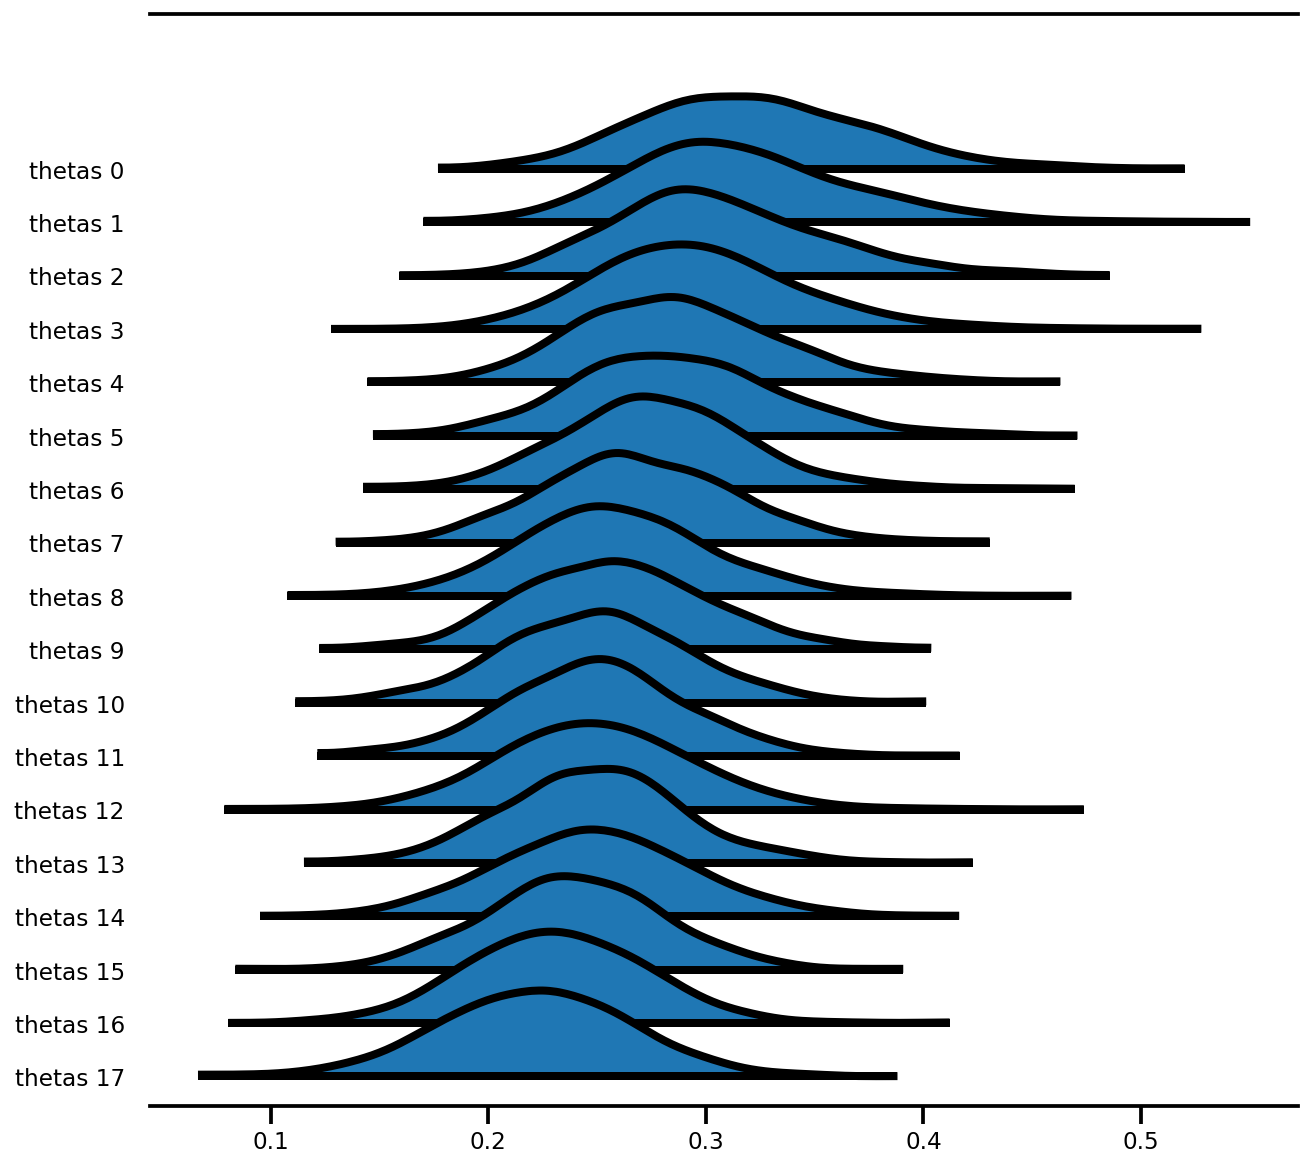

In [ ]:
az.plot_forest(az_trace,
               var_names=['thetas'],
               kind='ridgeplot',
               linewidth=4,
               combined=True,
               ridgeplot_overlap=1.5,
               figsize=(9, 8));

## 混合效应模型 (Radon)

PyMC3 文档[贝叶斯多层建模方法入门](https://docs.pymc.io/notebooks/multilevel_modeling.html)中的最后一个模型

对先验执行一些变更（缩小规模等）

In [ ]:
#@title Load raw data and clean up
srrs2 = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/srrs2.dat')

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips

cty = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/cty.dat')
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values.astype('float')

# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

对于具有复杂转换的模型，以函数式风格实现会使编写和测试更加方便。此外，它也能够使以编程方式生成以（小批量）输入数据为条件的 log_prob 函数变得更加方便：


In [ ]:
def affine(u_val, x_county, county, floor, gamma, eps, b):
  """Linear equation of the coefficients and the covariates, with broadcasting."""
  return (tf.transpose((gamma[..., 0]
                      + gamma[..., 1]*u_val[:, None]
                      + gamma[..., 2]*x_county[:, None]))
          + tf.gather(eps, county, axis=-1)
          + b*floor)


def gen_radon_model(u_val, x_county, county, floor,
                    mu0=tf.zeros([], dtype, name='mu0')):
  """Creates a joint distribution representing our generative process."""
  return tfd.JointDistributionSequential([
      # sigma_a
      tfd.HalfCauchy(loc=mu0, scale=5.),
      # eps
      lambda sigma_a: tfd.Sample(
          tfd.Normal(loc=mu0, scale=sigma_a), sample_shape=counties),
      # gamma
      tfd.Sample(tfd.Normal(loc=mu0, scale=100.), sample_shape=3),
      # b
      tfd.Sample(tfd.Normal(loc=mu0, scale=100.), sample_shape=1),
      # sigma_y
      tfd.Sample(tfd.HalfCauchy(loc=mu0, scale=5.), sample_shape=1),
      # likelihood
      lambda sigma_y, b, gamma, eps: tfd.Independent(
          tfd.Normal(
              loc=affine(u_val, x_county, county, floor, gamma, eps, b),
              scale=sigma_y
          ),
          reinterpreted_batch_ndims=1
      ),
  ])

contextual_effect2 = gen_radon_model(
    u.values,  xbar[county], county, floor_measure)

@tf.function(autograph=False)
def unnormalized_posterior_log_prob(sigma_a, gamma, eps, b, sigma_y):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return contextual_effect2.log_prob(
      [sigma_a, gamma, eps, b, sigma_y, log_radon])

assert [4] == unnormalized_posterior_log_prob(
    *contextual_effect2.sample(4)[:-1]).shape

In [ ]:
samples = contextual_effect2.sample(4)
pprint([s.shape for s in samples])

[TensorShape([4]),
 TensorShape([4, 85]),
 TensorShape([4, 3]),
 TensorShape([4, 1]),
 TensorShape([4, 1]),
 TensorShape([4, 919])]


In [ ]:
contextual_effect2.log_prob_parts(list(samples)[:-1] + [log_radon])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-3.95681828, -2.45693443, -2.53310078, -4.7717536 ])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-340.65975204, -217.11139018, -246.50498667, -369.79687704])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-20.49822449, -20.38052557, -18.63843525, -17.83096972])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-5.94765605, -5.91460848, -6.66169402, -5.53894593])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-2.10293999, -4.34186631, -2.10744955, -3.016717  ])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=
 array([-29022322.1413861 ,   -114422.36893361,  -8708500.81752865,
           -35061.92497235])>]

### Variational Inference

`JointDistribution*` 的一项非常强大的功能是您可以轻松地为变分推断生成逼近。例如，要执行平均场自动微分变分推断，您只需检查计算图并将所有未观察到的分布替换为正态分布。

#### 平均场自动微分变分推断

您还可以使用 [tensorflow_probability/python/experimental/vi](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/python/experimental/vi) 中的实验性功能来构建变分逼近，它们与下面使用的逻辑基本相同（即使用 JointDistribution 来构建逼近），但使用的是原始空间而非无界空间内的逼近输出。

In [ ]:
from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transform_fn, make_transformed_log_prob)

In [ ]:
# Wrap logp so that all parameters are in the Real domain
# copied and edited from tensorflow_probability/python/mcmc/transformed_kernel.py
unconstraining_bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

unnormalized_log_prob = lambda *x: contextual_effect2.log_prob(x + (log_radon,))

contextual_effect_posterior = make_transformed_log_prob(
    unnormalized_log_prob,
    unconstraining_bijectors,
    direction='forward',
    # TODO(b/72831017): Disable caching until gradient linkage
    # generally works.
    enable_bijector_caching=False)

In [ ]:
# debug
if True:
  # Check the two versions of log_prob - they should be different given the Jacobian
  rv_samples = contextual_effect2.sample(4)

  _inverse_transform = make_transform_fn(unconstraining_bijectors, 'inverse')
  _forward_transform = make_transform_fn(unconstraining_bijectors, 'forward')

  pprint([
      unnormalized_log_prob(*rv_samples[:-1]),
      contextual_effect_posterior(*_inverse_transform(rv_samples[:-1])),
      unnormalized_log_prob(
          *_forward_transform(
              tf.zeros_like(a, dtype=dtype) for a in rv_samples[:-1])
      ),
      contextual_effect_posterior(
          *[tf.zeros_like(a, dtype=dtype) for a in rv_samples[:-1]]
      ),
  ])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1.73354969e+04, -5.51622488e+04, -2.77754609e+08, -1.09065161e+07])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1.73331358e+04, -5.51582029e+04, -2.77754602e+08, -1.09065134e+07])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1992.10420767, -1992.10420767, -1992.10420767, -1992.10420767])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-1992.10420767, -1992.10420767, -1992.10420767, -1992.10420767])>]


In [ ]:
# Build meanfield ADVI for a jointdistribution
# Inspect the input jointdistribution and replace the list of distribution with
# a list of Normal distribution, each with the same shape.
def build_meanfield_advi(jd_list, observed_node=-1):
  """
  The inputted jointdistribution needs to be a batch version
  """
  # Sample to get a list of Tensors
  list_of_values = jd_list.sample(1)  # <== sample([]) might not work
  
  # Remove the observed node
  list_of_values.pop(observed_node)
  
  # Iterate the list of Tensor to a build a list of Normal distribution (i.e.,
  # the Variational posterior)
  distlist = []
  for i, value in enumerate(list_of_values):
    dtype = value.dtype
    rv_shape = value[0].shape
    loc = tf.Variable(
        tf.random.normal(rv_shape, dtype=dtype),
        name='meanfield_%s_mu' % i,
        dtype=dtype)
    scale = tfp.util.TransformedVariable(
        tf.fill(rv_shape, value=tf.constant(0.02, dtype)),
        tfb.Softplus(),
        name='meanfield_%s_scale' % i,
    )

    approx_node = tfd.Normal(loc=loc, scale=scale)
    if loc.shape == ():
      distlist.append(approx_node)
    else:
      distlist.append(
          # TODO: make the reinterpreted_batch_ndims more flexible (for 
          # minibatch etc)
          tfd.Independent(approx_node, reinterpreted_batch_ndims=1)
      )

  # pass list to JointDistribution to initiate the meanfield advi
  meanfield_advi = tfd.JointDistributionSequential(distlist)
  return meanfield_advi

In [ ]:
advi = build_meanfield_advi(contextual_effect2, observed_node=-1)

# Check the logp and logq
advi_samples = advi.sample(4)
pprint([
  advi.log_prob(advi_samples),
  contextual_effect_posterior(*advi_samples)
  ])

[<tf.Tensor: shape=(4,), dtype=float64, numpy=array([231.26836839, 229.40755095, 227.10287879, 224.05914594])>,
 <tf.Tensor: shape=(4,), dtype=float64, numpy=array([-10615.93542431, -11743.21420129, -10376.26732337, -11338.00600103])>]


In [ ]:
opt = tf.optimizers.Adam(learning_rate=.1)

@tf.function(experimental_compile=True)
def run_approximation():
  loss_ = tfp.vi.fit_surrogate_posterior(
        contextual_effect_posterior,
        surrogate_posterior=advi,
        optimizer=opt,
        sample_size=10,
        num_steps=300)
  return loss_

loss_ = run_approximation()

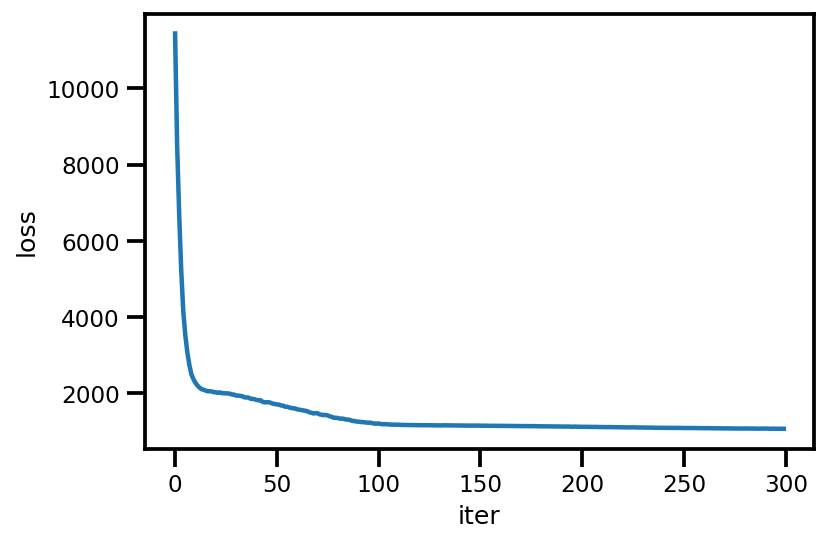

In [ ]:
plt.plot(loss_);
plt.xlabel('iter');
plt.ylabel('loss');

In [ ]:
graph_info = contextual_effect2.resolve_graph()
approx_param = dict()
free_param = advi.trainable_variables
for i, (rvname, param) in enumerate(graph_info[:-1]):
  approx_param[rvname] = {"mu": free_param[i*2].numpy(),
                          "sd": free_param[i*2+1].numpy()}

In [ ]:
approx_param.keys()

dict_keys(['sigma_a', 'eps', 'gamma', 'b', 'sigma_y'])

In [ ]:
approx_param['gamma']

{'mu': array([1.28145814, 0.70365287, 1.02689857]),
 'sd': array([-3.6604972 , -2.68153218, -2.04176524])}

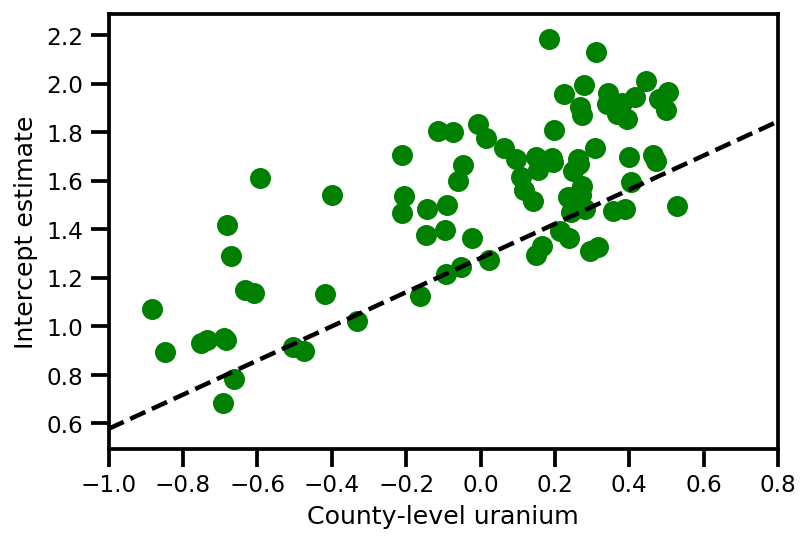

In [ ]:
a_means = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps']['mu'][county])
_, index = np.unique(county, return_index=True)
plt.scatter(u.values[index], a_means[index], color='g')

xvals = np.linspace(-1, 0.8)
plt.plot(xvals, 
         approx_param['gamma']['mu'][0]+approx_param['gamma']['mu'][1]*xvals, 
         'k--')
plt.xlim(-1, 0.8)

plt.xlabel('County-level uranium');
plt.ylabel('Intercept estimate');

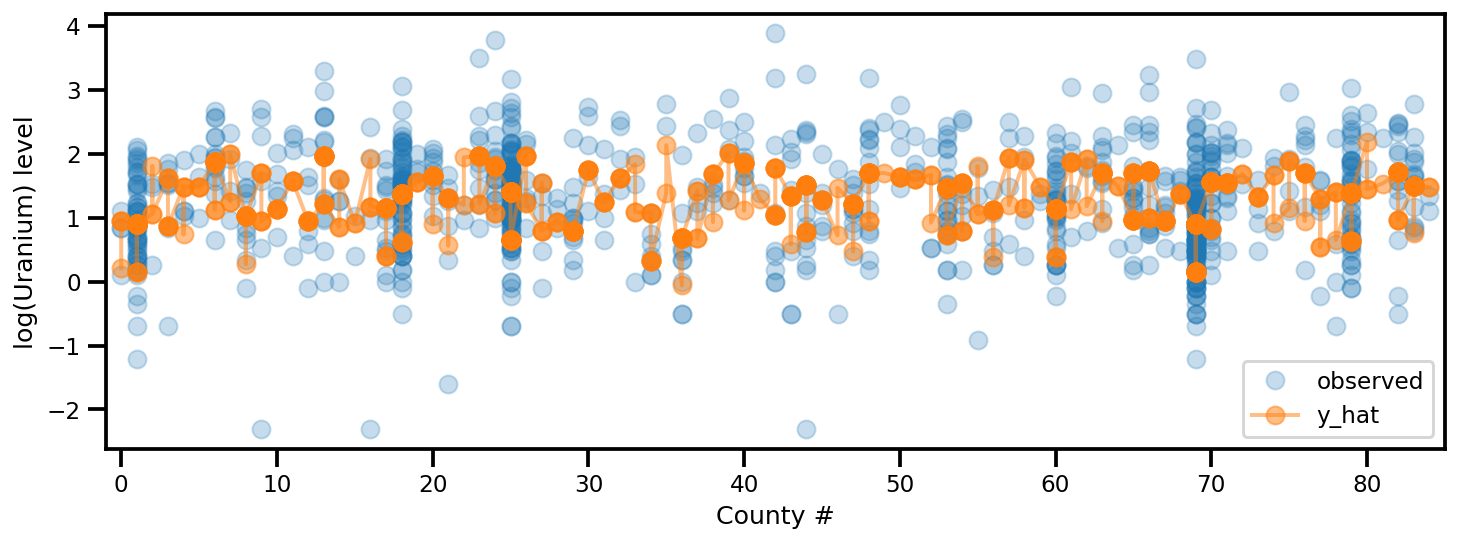

In [ ]:
y_est = (approx_param['gamma']['mu'][0] 
        + approx_param['gamma']['mu'][1]*u.values
        + approx_param['gamma']['mu'][2]*xbar[county]
        + approx_param['eps']['mu'][county]
        + approx_param['b']['mu']*floor_measure)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(county, log_radon, 'o', alpha=.25, label='observed')
ax.plot(county, y_est, '-o', lw=2, alpha=.5, label='y_hat')
ax.set_xlim(-1, county.max()+1)
plt.legend(loc='lower right')
ax.set_xlabel('County #')
ax.set_ylabel('log(Uranium) level');

#### 满秩自动微分变分推断

对于满秩自动微分变分推断，我们想逼近多元高斯分布后验。

In [ ]:
USE_FULLRANK = True

In [ ]:
*prior_tensors, _ = contextual_effect2.sample()

mapper = Mapper(prior_tensors,
                [tfb.Identity() for _ in prior_tensors],
                contextual_effect2.event_shape[:-1])

In [ ]:
rv_shape = ps.shape(mapper.flatten_and_concat(mapper.list_of_tensors))
init_val = tf.random.normal(rv_shape, dtype=dtype)
loc = tf.Variable(init_val, name='loc', dtype=dtype)

if USE_FULLRANK:
  # cov_param = tfp.util.TransformedVariable(
  #     10. * tf.eye(rv_shape[0], dtype=dtype),
  #     tfb.FillScaleTriL(),
  #     name='cov_param'
  #     )
  FillScaleTriL = tfb.FillScaleTriL(
        diag_bijector=tfb.Chain([
          tfb.Shift(tf.cast(.01, dtype)),
          tfb.Softplus(),
          tfb.Shift(tf.cast(np.log(np.expm1(1.)), dtype))]),
        diag_shift=None)
  cov_param = tfp.util.TransformedVariable(
      .02 * tf.eye(rv_shape[0], dtype=dtype), 
      FillScaleTriL,
      name='cov_param')
  advi_approx = tfd.MultivariateNormalTriL(
      loc=loc, scale_tril=cov_param)
else:
  # An alternative way to build meanfield ADVI.
  cov_param = tfp.util.TransformedVariable(
      .02 * tf.ones(rv_shape, dtype=dtype),
      tfb.Softplus(),
      name='cov_param'
      )
  advi_approx = tfd.MultivariateNormalDiag(
      loc=loc, scale_diag=cov_param)

contextual_effect_posterior2 = lambda x: contextual_effect_posterior(
    *mapper.split_and_reshape(x)
)

# Check the logp and logq
advi_samples = advi_approx.sample(7)
pprint([
  advi_approx.log_prob(advi_samples),
  contextual_effect_posterior2(advi_samples)
  ])

[<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([238.81841799, 217.71022639, 234.57207103, 230.0643819 ,
       243.73140943, 226.80149702, 232.85184209])>,
 <tf.Tensor: shape=(7,), dtype=float64, numpy=
array([-3638.93663169, -3664.25879314, -3577.69371677, -3696.25705312,
       -3689.12130489, -3777.53698383, -3659.4982734 ])>]


In [ ]:
learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10,
    decay_rate=0.99,
    staircase=True)

opt = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function(experimental_compile=True)
def run_approximation():
  loss_ = tfp.vi.fit_surrogate_posterior(
        contextual_effect_posterior2,
        surrogate_posterior=advi_approx,
        optimizer=opt,
        sample_size=10,
        num_steps=1000)
  return loss_

loss_ = run_approximation()

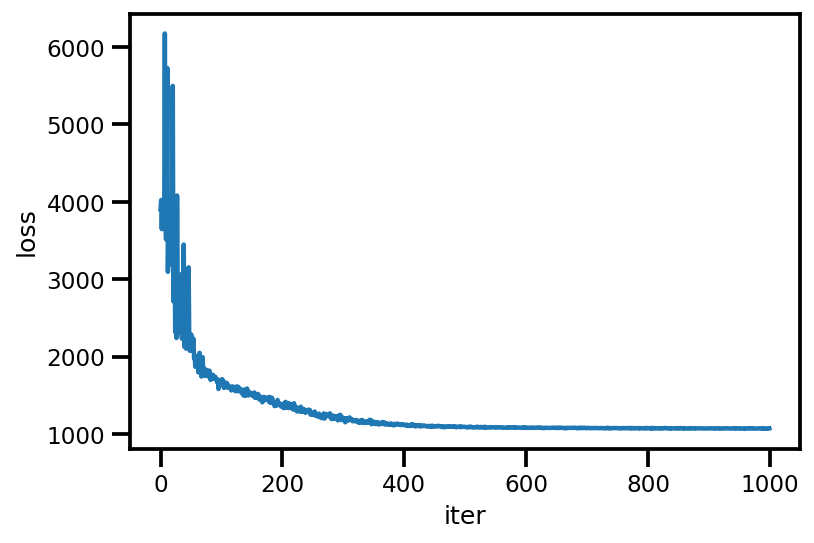

In [ ]:
plt.plot(loss_);
plt.xlabel('iter');
plt.ylabel('loss');

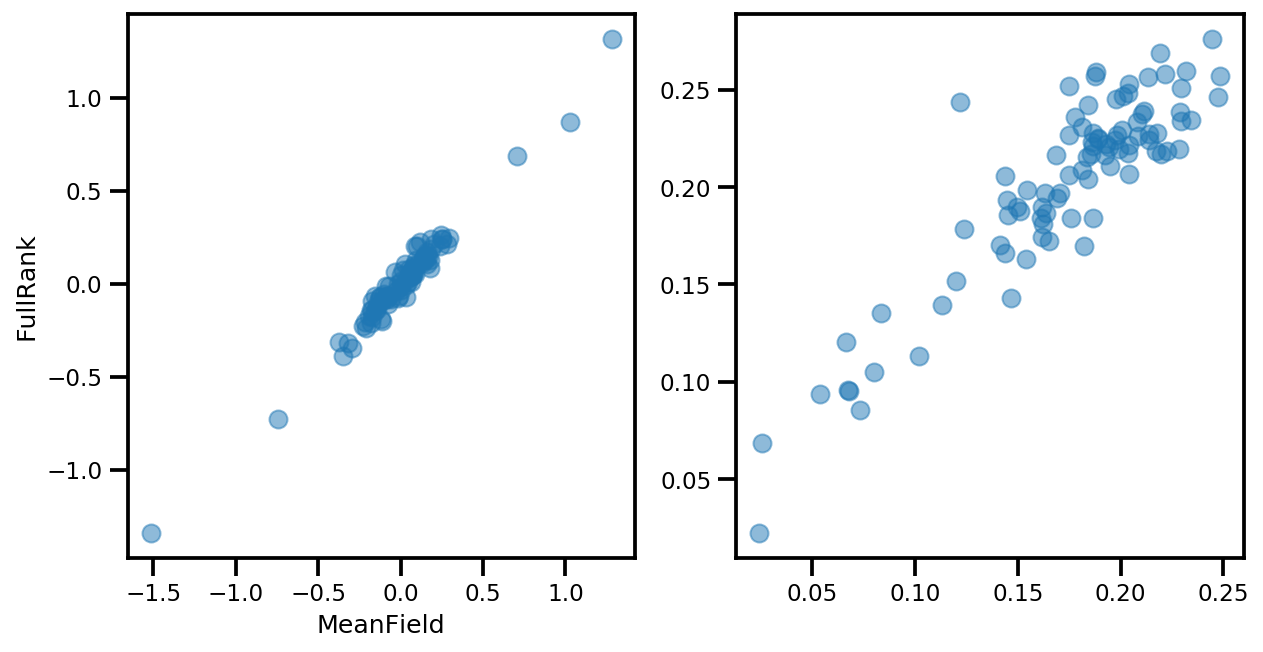

In [ ]:
# debug
if True:
  _, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].plot(mapper.flatten_and_concat(advi.mean()), advi_approx.mean(), 'o', alpha=.5)
  ax[1].plot(mapper.flatten_and_concat(advi.stddev()), advi_approx.stddev(), 'o', alpha=.5)
  ax[0].set_xlabel('MeanField')
  ax[0].set_ylabel('FullRank')

In [ ]:
graph_info = contextual_effect2.resolve_graph()
approx_param = dict()

free_param_mean = mapper.split_and_reshape(advi_approx.mean())
free_param_std = mapper.split_and_reshape(advi_approx.stddev())
for i, (rvname, param) in enumerate(graph_info[:-1]):
  approx_param[rvname] = {"mu": free_param_mean[i].numpy(),
                          "cov_info": free_param_std[i].numpy()}

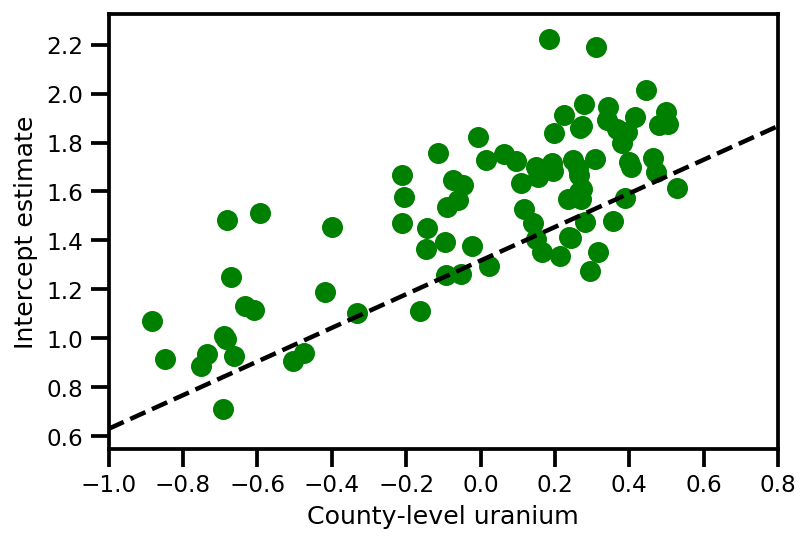

In [ ]:
a_means = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps']['mu'][county])
_, index = np.unique(county, return_index=True)
plt.scatter(u.values[index], a_means[index], color='g')

xvals = np.linspace(-1, 0.8)
plt.plot(xvals, 
         approx_param['gamma']['mu'][0]+approx_param['gamma']['mu'][1]*xvals, 
         'k--')
plt.xlim(-1, 0.8)

plt.xlabel('County-level uranium');
plt.ylabel('Intercept estimate');

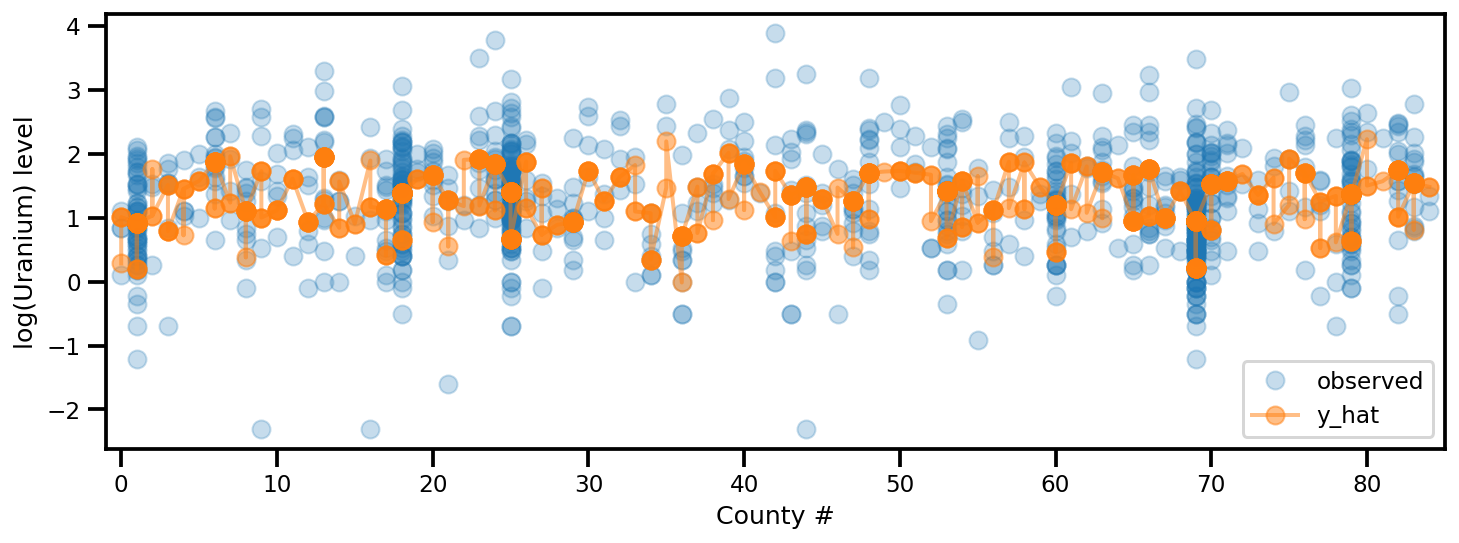

In [ ]:
y_est = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps']['mu'][county]
         + approx_param['b']['mu']*floor_measure)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(county, log_radon, 'o', alpha=.25, label='observed')
ax.plot(county, y_est, '-o', lw=2, alpha=.5, label='y_hat')
ax.set_xlim(-1, county.max()+1)
plt.legend(loc='lower right')
ax.set_xlabel('County #')
ax.set_ylabel('log(Uranium) level');

## 贝塔-伯努利混合模型

一种混合模型，其中多个审查者使用未知（真实）潜在标签标记某些条目。

In [ ]:
dtype = tf.float32

In [ ]:
n = 50000    # number of examples reviewed
p_bad_ = 0.1 # fraction of bad events
m = 5        # number of reviewers for each example
rcl_ = .35 + np.random.rand(m)/10
prc_ = .65 + np.random.rand(m)/10

# PARAMETER TRANSFORMATION
tpr = rcl_
fpr = p_bad_*tpr*(1./prc_-1.)/(1.-p_bad_)
tnr = 1 - fpr

# broadcast to m reviewer.
batch_prob = np.asarray([tpr, fpr]).T
mixture = tfd.Mixture(
    tfd.Categorical(
        probs=[p_bad_, 1-p_bad_]),
    [
        tfd.Independent(tfd.Bernoulli(probs=tpr), 1),
        tfd.Independent(tfd.Bernoulli(probs=fpr), 1),
    ])
# Generate reviewer response
X_tf = mixture.sample([n])

# run once to always use the same array as input
# so we can compare the estimation from different
# inference method.
X_np = X_tf.numpy()

In [ ]:
# batched Mixture model
mdl_mixture = tfd.JointDistributionSequential([
    tfd.Sample(tfd.Beta(5., 2.), m),
    tfd.Sample(tfd.Beta(2., 2.), m),
    tfd.Sample(tfd.Beta(1., 10), 1),
    lambda p_bad, rcl, prc: tfd.Sample(
        tfd.Mixture(
            tfd.Categorical(
                probs=tf.concat([p_bad, 1.-p_bad], -1)),
            [
              tfd.Independent(tfd.Bernoulli(
                  probs=rcl), 1),
              tfd.Independent(tfd.Bernoulli(
                  probs=p_bad*rcl*(1./prc-1.)/(1.-p_bad)), 1)
             ]
      ), (n, )), 
    ])

mdl_mixture.resolve_graph()

(('prc', ()), ('rcl', ()), ('p_bad', ()), ('x', ('p_bad', 'rcl', 'prc')))

In [ ]:
prc, rcl, p_bad, x = mdl_mixture.sample(4)
x.shape

TensorShape([4, 50000, 5])

In [ ]:
mdl_mixture.log_prob_parts([prc, rcl, p_bad, X_np[np.newaxis, ...]])

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.4828572, 2.957961 , 2.9355168, 2.6116824], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.14646745,  1.3308513 ,  1.1205603 ,  0.5441705 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.3733709, 1.8020535, 2.1865845, 1.5701319], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-54326.664, -52683.93 , -64407.67 , -55007.895], dtype=float32)>]

#### 推断（ No-U-Turn 采样器）

In [ ]:
nchain = 10
prc, rcl, p_bad, _ = mdl_mixture.sample(nchain)
initial_chain_state = [prc, rcl, p_bad]

# Since MCMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfb.Sigmoid(),       # Maps R to [0, 1].
    tfb.Sigmoid(),       # Maps R to [0, 1].
    tfb.Sigmoid(),       # Maps R to [0, 1].
]
step_size = [tf.cast(i, dtype=dtype) for i in [1e-3, 1e-3, 1e-3]]

X_expanded = X_np[np.newaxis, ...]
target_log_prob_fn = lambda *x: mdl_mixture.log_prob(x + (X_expanded, ))

samples, sampler_stat = run_chain(
    initial_chain_state, step_size, target_log_prob_fn, 
    unconstraining_bijectors, burnin=100)

In [ ]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['Precision', 'Recall', 'Badness Rate']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

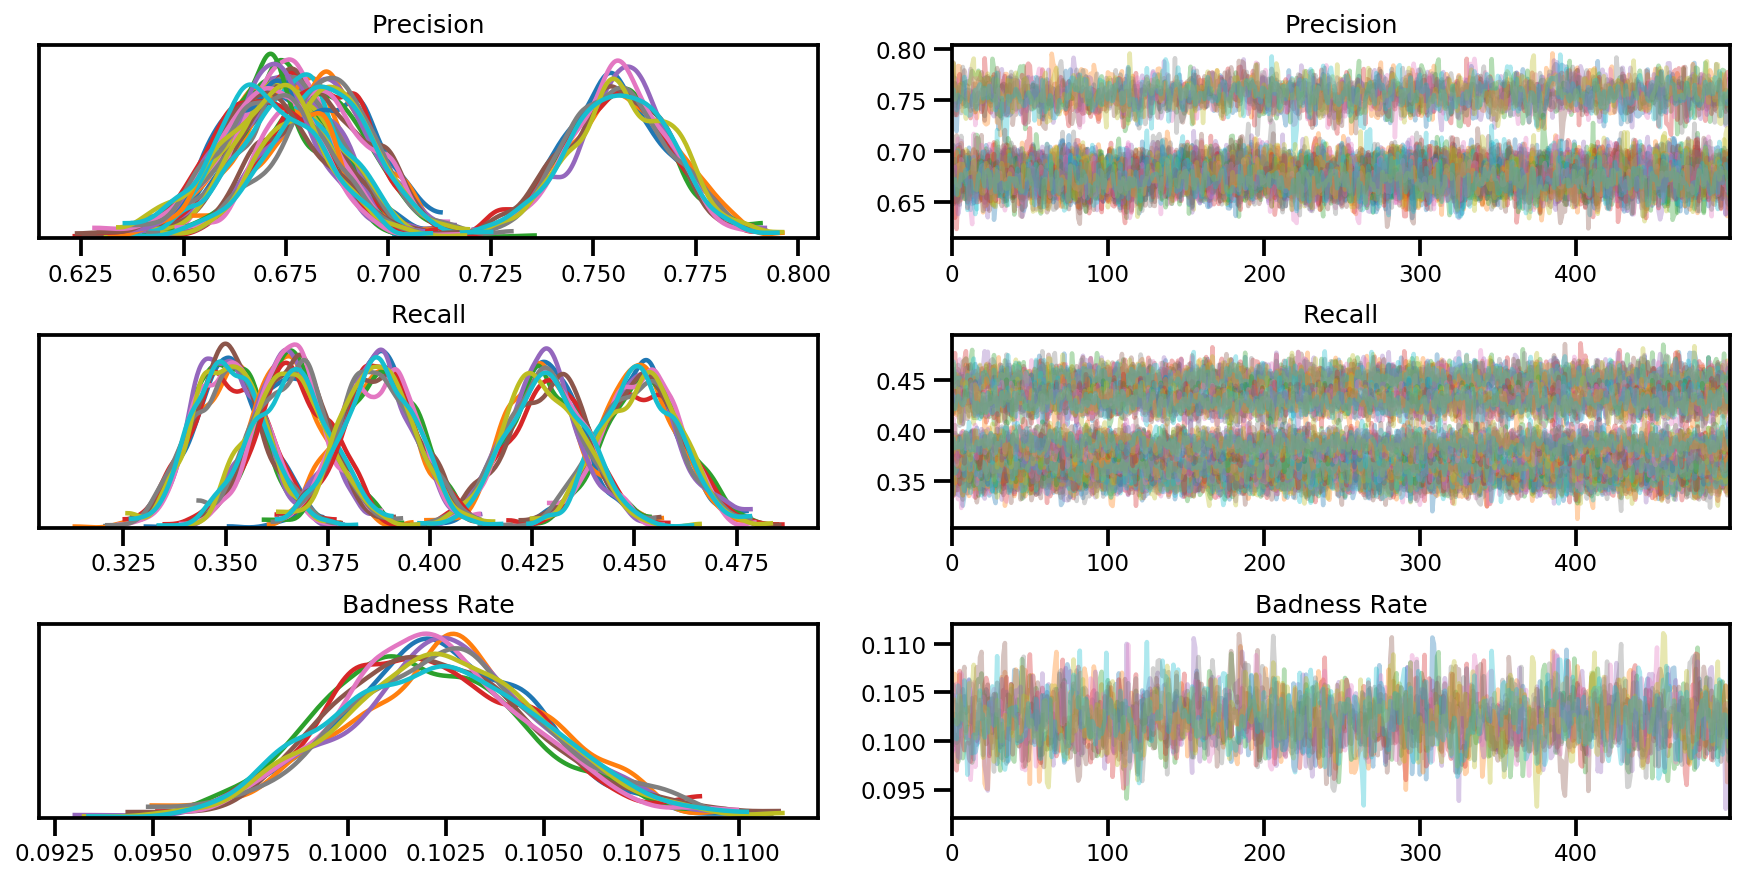

In [ ]:
axes = az.plot_trace(az_trace, compact=True);